## Single axis and small fit domain test

In [1]:
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
# import electrode
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped, utils)
from scipy.signal import argrelextrema
import math
from scipy.optimize import minimize

In [3]:
# n electrodes per row (10 default)
# number of rows (2 default)
# width of electrode
# height of electrode
# spacing between electrodes
# tuple of coordinates to start each row
    # top row x-coordinate (bottom left point)
    # top row y-coordinate (bottom left point)

#...
# bottom row x-coordinate (bottom left point)
# bottom row y-coordinate (bottom left point)
def trap(spacing,
        gnd_width, gnd_height, gnd_start_pos,
        dc_width, dc_height, dc_start_pos,
        rf_width, rf_height, rf_start_pos,
        dc_mid_width, dc_mid_height, dc_mid_start_pos,
        n=9, r=2):

    electrodes = []

    #add dc electrodes
    #define effective size, without dielectric gaps
    w_eff = dc_width + spacing
    h_eff = dc_height + spacing
    #start with top row
    row = 0
    for sp in dc_start_pos:
        xp_start = sp[0] - spacing/2
        yp = sp[1] - spacing/2
        for electrode in range(n):
            # e.g. electrode 2 would be leftmost in top row
            # e.g. electrode 12 would be leftmost in bottom row
            electrode_id = str(row * (n+1) + electrode + 2)
            x_shift = electrode * w_eff
            xp = xp_start + x_shift
            # print(xp)
            electrodes.append(
                (electrode_id, [[
                    (xp, yp),
                    (xp + w_eff, yp),
                    (xp + w_eff, yp + h_eff),
                    (xp, yp + h_eff)
                ]])
            )
        row += 1
    dc_mid_w_eff = dc_mid_width + spacing
    dc_mid_h_eff = dc_mid_height + spacing
    for i in range (2):
        xp = dc_mid_start_pos[i][0] - spacing/2
        yp = dc_mid_start_pos[i][1] - spacing/2
        dc_mid_id = str(10*i + 1)
        electrodes.append(
            (dc_mid_id, [[
                (xp, yp),
                (xp + dc_mid_w_eff, yp),
                (xp + dc_mid_w_eff, yp + dc_mid_h_eff),
                (xp, yp + dc_mid_h_eff)
            ]])
        )
    
    # add rf electrodes
    rf_w_eff = rf_width + spacing
    rf_h_eff = rf_height + spacing
    rf_electrodes = []
    for i in range (2):
        xp = rf_start_pos[i][0] - spacing/2
        yp = rf_start_pos[i][1] - spacing/2
        # rf_e_id = str('r'+i+1) #use this for unique rf electrode id
        rf_electrodes.append([
            (xp, yp),
            (xp + rf_w_eff, yp),
            (xp + rf_w_eff, yp + rf_h_eff),
            (xp, yp + rf_h_eff)
        ])
        rf_e_id = str('r')
    electrodes.append(
        (rf_e_id, rf_electrodes)
    )
    
    # add gnd electrodes
    #define effective size, without dielectric gaps
    gnd_w_eff = gnd_width + spacing
    gnd_h_eff = gnd_height + spacing
    gnd_electrodes = []
    for sp in gnd_start_pos:
        xp = sp[0] - spacing/2
        yp = sp[1] - spacing/2
        for gnd in range(n):
            gnd_id = 'gnd'
            gnd_electrodes.append([
                (xp, yp),
                (xp + gnd_w_eff, yp),
                (xp + gnd_w_eff, yp + gnd_h_eff),
                (xp, yp + gnd_h_eff)
            ])
    electrodes.append(
        (gnd_id, gnd_electrodes)
    )
    
    s = System([PolygonPixelElectrode(name=n, paths=map(np.array, p))
                for n, p in electrodes])
    # apply rf potential to electrode
    # s['r'].rf = 1.
    return s

In [56]:
print(s.names)

['2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '1', '11', 'r', 'gnd']


[[-500.   602.5]]


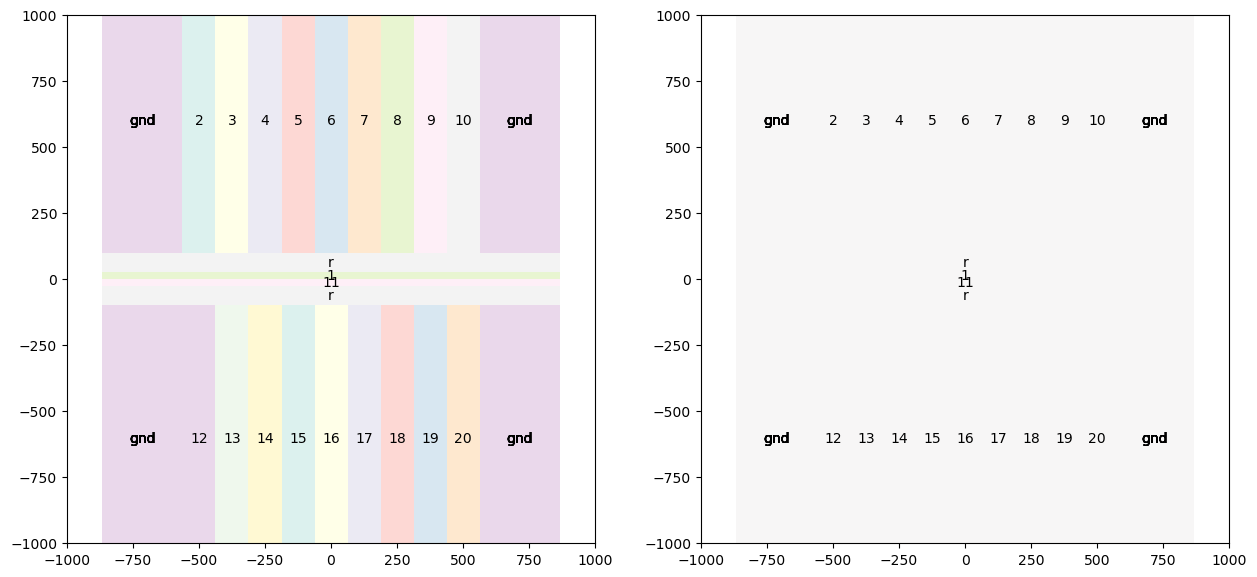

In [4]:
spacing = 5.
n = 9
dc_width = 120.
# dc_height = 1000.
gnd_width = 300.
gnd_height = 1000.
dc_height = 1000.
dc_mid_height = 20.
# dc_mid_width = n * dc_width + (n-1) * spacing
dc_mid_width = n * dc_width + (n+1) * spacing + 2 * gnd_width
rf_height = 70.
# rf_width = n * dc_width + (n-1) * spacing
rf_width = n * dc_width + (n+1) * spacing + 2 * gnd_width

leftmost_electrode_x = -(4.5*dc_width + 4*spacing)
rightmost_electrode_x = (4.5*dc_width + 4*spacing)

gnd_start_pos = [(leftmost_electrode_x-gnd_width-spacing, (2.5*spacing + dc_mid_height + rf_height)),
                (leftmost_electrode_x-gnd_width-spacing, -(2.5*spacing + dc_mid_height + rf_height + dc_height)),
                (rightmost_electrode_x+spacing, (2.5*spacing + dc_mid_height + rf_height)),
                (rightmost_electrode_x+spacing, -(2.5*spacing + dc_mid_height + rf_height + dc_height))
                ]

dc_start_pos = [(leftmost_electrode_x, (2.5*spacing + dc_mid_height + rf_height)),
                (leftmost_electrode_x, -(2.5*spacing + dc_mid_height + rf_height + dc_height))]
rf_start_pos = [(leftmost_electrode_x-gnd_width-spacing, (1.5*spacing + dc_mid_height)),
                (leftmost_electrode_x-gnd_width-spacing, -(1.5*spacing + dc_mid_height + rf_height))]
dc_mid_start_pos = [(leftmost_electrode_x-gnd_width-spacing, (.5*spacing)),
                (leftmost_electrode_x-gnd_width-spacing, -(.5*spacing +dc_mid_height))]

s = trap(spacing,
        gnd_width, gnd_height, gnd_start_pos,
        dc_width, dc_height, dc_start_pos,
        rf_width, rf_height, rf_start_pos,
        dc_mid_width, dc_mid_height, dc_mid_start_pos,
        n, r=2)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
print(s["2"].to_points().points) # use this to get the centroid coordinates of an electrode
s.plot(ax[0])
# s.plot_voltages(ax[1], u=s.rfs)
# s['2'].dc = 1.
s.plot_voltages(ax[1])

r= 1000
for axi in ax.flat:
    axi.set_aspect("equal")
    axi.set_xlim(-r, r)
    axi.set_ylim(-r, r)

In [5]:
l = 1e-6 # µm length scale
u = 20. # V rf peak voltage
m = 40*ct.atomic_mass # 40Ca+ ion mass
q = 1*ct.elementary_charge # ion charge

f = 30e6
o = 2*np.pi*f # rf frequency in rad/s
s["r"].rf = u*np.sqrt(q/m)/(2*l*o)

# searches for potential minimum point given the starting point
x0 = s.minimum((0, 0, 1.), axis=(1, 2))
# using lengthscale 1e-6 m gives the right height for minimum at 50µm
# x0 = np.array([0.0, 0.0, 50.0])
# print(x0)

for line in s.analyze_static(x0, axis=(1, 2), m=m, q=q, l=l, o=o):
    print(line)

parameters:
 f=30 MHz, m=40 amu, q=1 qe, l=1 µm, scale=4.12 V'/V_SI
corrdinates:
 analyze point: [0.00000000e+00 4.34002626e-15 4.97375282e+01]
               ([0.00000000e+00 4.34002626e-15 4.97375282e+01] µm)
 minimum is at offset: [0. 0. 0.]
                      ([0. 0. 0.] µm)
potential:
 dc electrical: 0 eV
 rf pseudo: 6.5e-09 eV
 saddle offset: [-1.74598588e-01  4.01329185e-08  7.90990106e-03]
               ([-1.74598588e-01  4.01329185e-08  7.90990106e-03] µm)
 saddle height: -6.5e-09 eV
force:
 dc electrical: [0. 0. 0.] eV/l
               ([0. 0. 0.] eV/m)
 rf pseudo: [ 0.00000000e+00  1.13588964e-18 -1.65526020e-06] eV/l
           ([ 0.00000000e+00  1.13588964e-12 -1.65526020e+00] eV/m)
modes:
 pp+dc normal curvatures: [-1.18909507e-12  2.09255087e-04  2.09411976e-04]
 motion is bounded: True
 pseudopotential modes:
  a: nan MHz, [1. 0. 0.]
  b: 3.576 MHz, [-0.00000000e+00 -1.00000000e+00 -4.33757064e-13]
  c: 3.577 MHz, [ 0.00000000e+00 -4.33757064e-13  1.00000000e+00]
  

/opt/homebrew/anaconda3/envs/pqe7/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-macosx-10.9-x86_64.egg/electrode/system.py:879: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = np.sqrt(q*curves/m)/(2*np.pi*l)


In [22]:
def single_axis(axis, bounds, res, shift={'z': 50}):
    ts = np.linspace(bounds[0], bounds[1], res)
    zeros = np.zeros(res)
    line = []
    if (axis == 'x'):
        line = np.column_stack([ts.T, zeros, zeros])
    if (axis == 'y'):
        line = np.column_stack([zeros, ts.T, zeros])
    if (axis == 'z'):
        line = np.column_stack([zeros, zeros, ts.T])

    # to shift line height
    for key, val in shift.items():
        if (key == 'x'):
            line += np.column_stack([np.ones(res) * val, zeros, zeros])
        if (key == 'y'):
            line += np.column_stack([zeros, np.ones(res) * val, zeros])
        if (key == 'z'):
            line += np.column_stack([zeros, zeros, np.ones(res) * val])
    return line

def make_xy_grid_flat(x_grid_bounds, y_grid_bounds, z, grid_res):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], grid_res[0])
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], grid_res[1])
    grid = []
    for y in ts_y:
        for x in ts_x:
            grid.append([x, y, z])
    return grid, ts_x, ts_y

def make_xyz_grid_flat(x_grid_bounds, y_grid_bounds, z_grid_bounds, grid_res):
    ts_x = np.linspace(x_grid_bounds[0], x_grid_bounds[1], grid_res[0])
    ts_y = np.linspace(y_grid_bounds[0], y_grid_bounds[1], grid_res[1])
    ts_z = np.linspace(z_grid_bounds[0], z_grid_bounds[1], grid_res[2])
    grid = []
    for z in ts_z:
        for y in ts_y:
            for x in ts_x:
                grid.append([x, y, z])
    return grid, ts_x, ts_y, ts_z

In [150]:
# define fit params
length = 20. #µm
res = 301

# create fit axes
x = single_axis('x', (-length/2,length/2), res)
y = single_axis('y', (-length/2,length/2), res)
z = single_axis('z', (-length/2,length/2), res)

# find individual potential contributions
p_x = s.individual_potential(x, 0)
p_y = s.individual_potential(y, 0)
p_z = s.individual_potential(z, 0)

In [91]:
# solve for 1 electrode along 1 axis
def solve_axes_coeffs(axis, p, order=0):
    #want to solve equation f = c + a_x1 * x + a_x2 * x^2
    # create matrix of coordinate values
    c = np.ones(axis.shape[0])
    A = np.column_stack([c, axis])
    for i in range(2, order+1):
        A = np.column_stack([A, axis**i])
    c_arr = []
    c, residuals, rank, s = np.linalg.lstsq(A, p, rcond=None)
    # print(residuals)
    c_arr.append(c)
    # print(f'electrode {el_i}:', c)
    return c_arr, A, residuals[0]

# c_arr = solve_axes_coeffs(p_x, x[:,0], order=2)

Plot voltages along each axis

In [129]:
import pandas as pd
from datetime import datetime

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_33160/3708504551.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, num_axes, figsize=(fig_width, 1/2*fig_width))


['id', 'c_x0', 'c_x1', 'c_x2', 'c_y0', 'c_y1', 'c_y2', 'c_z0', 'c_z1', 'c_z2', 'residuals_x', 'residuals_y', 'residuals_z']


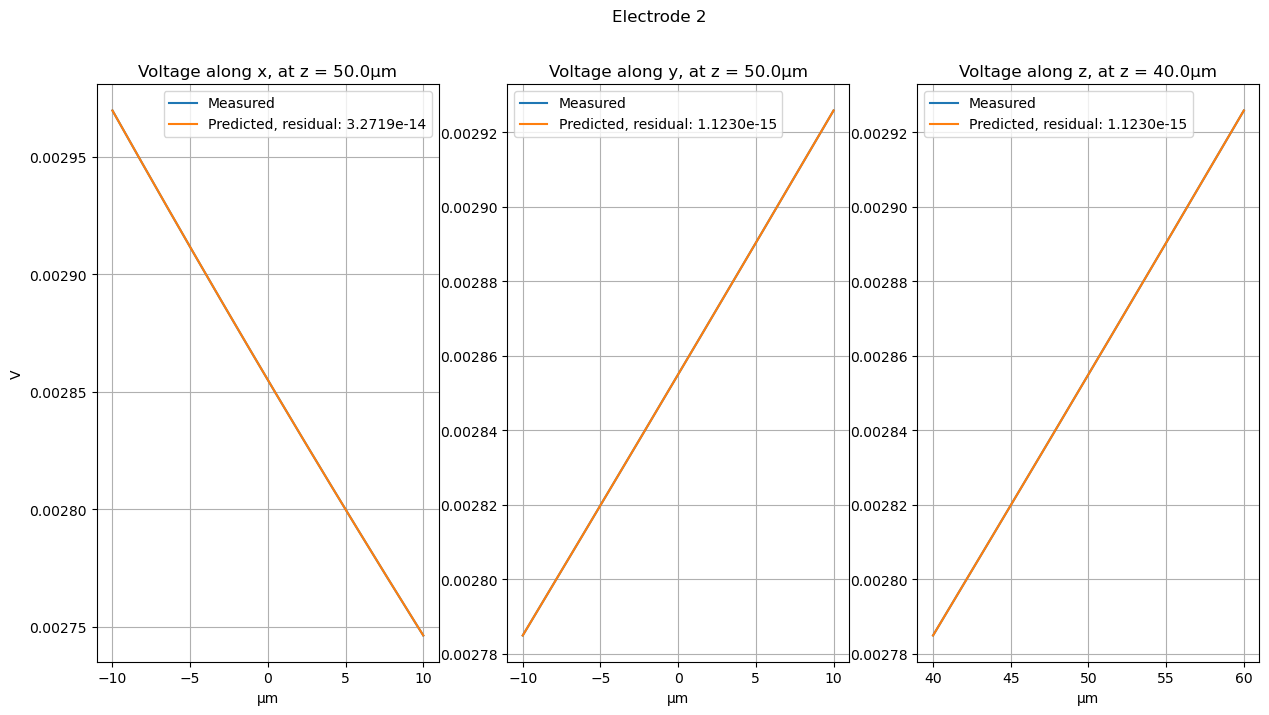

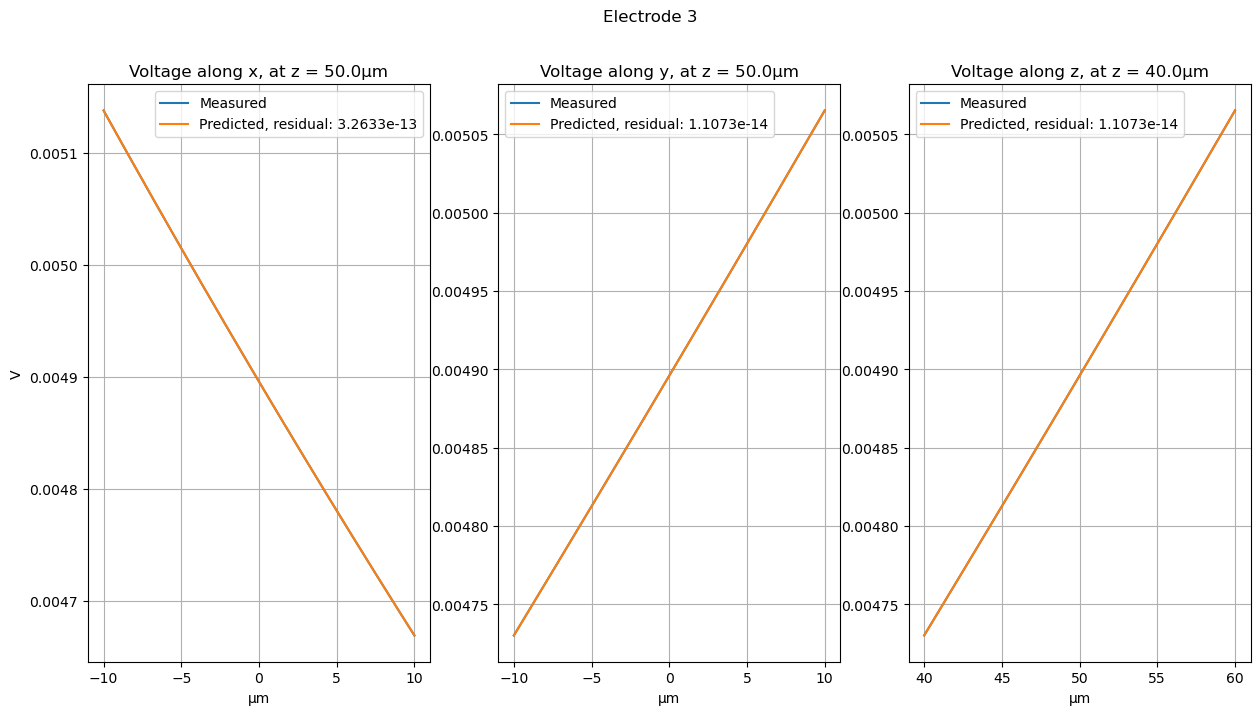

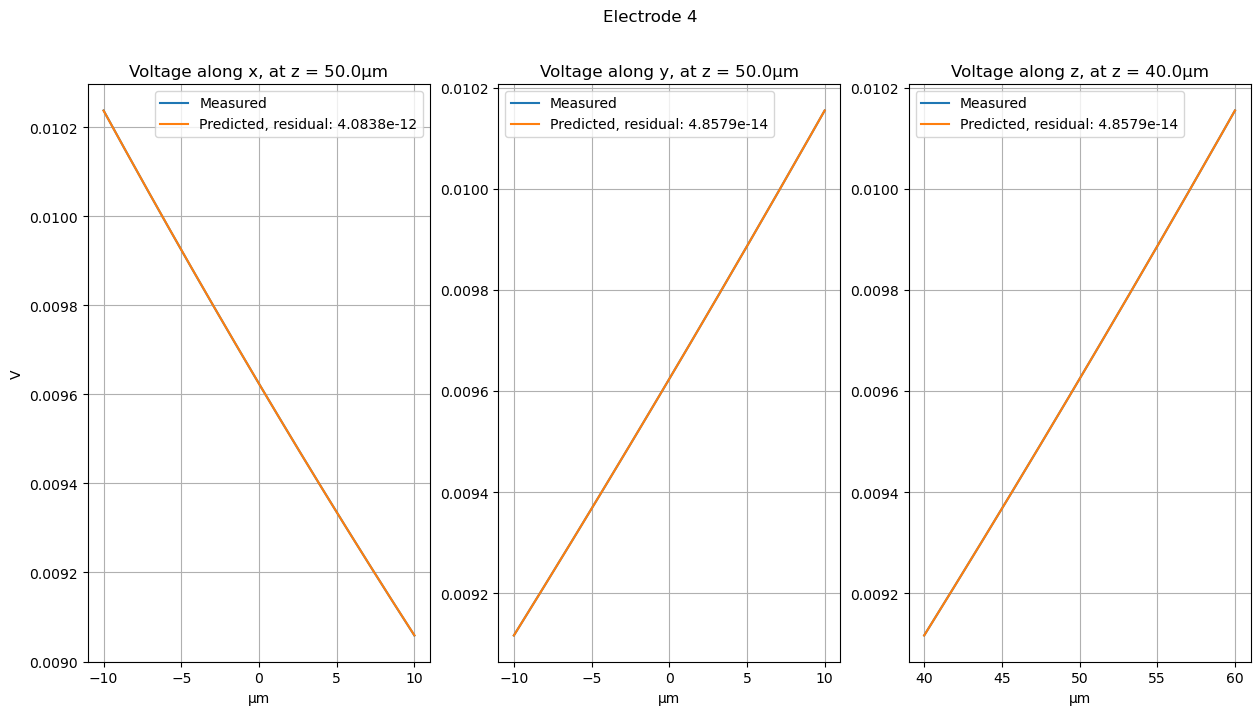

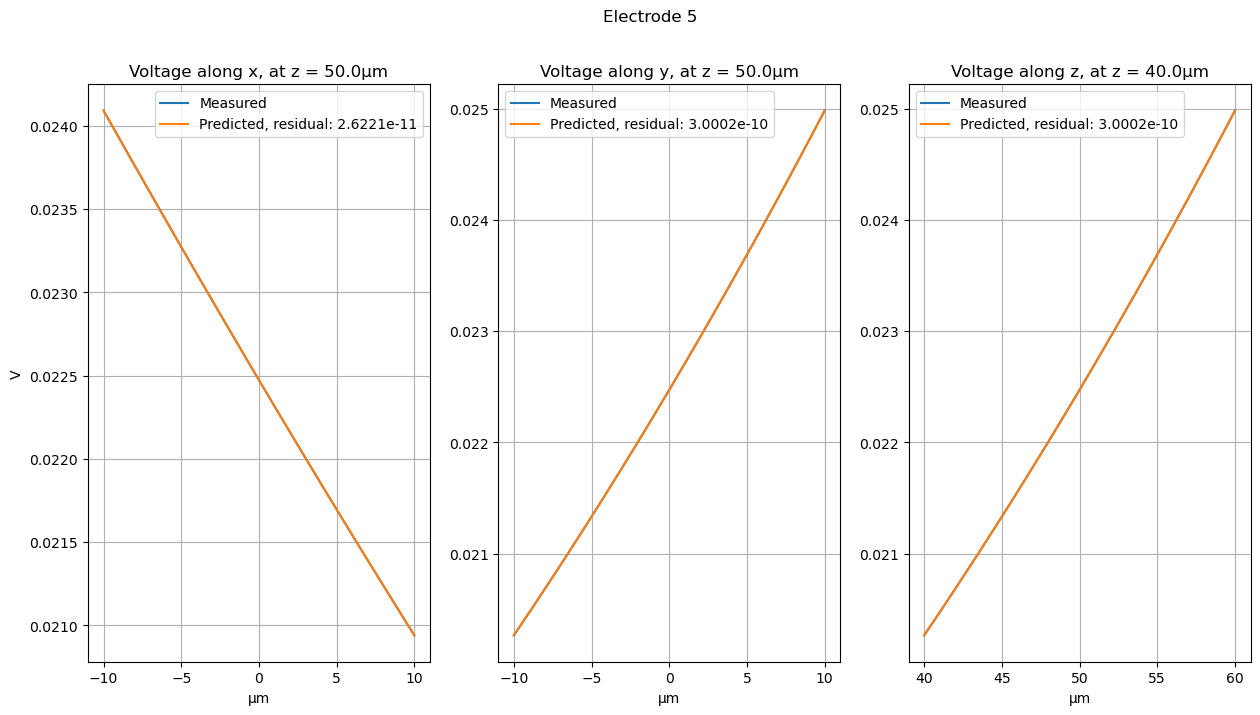

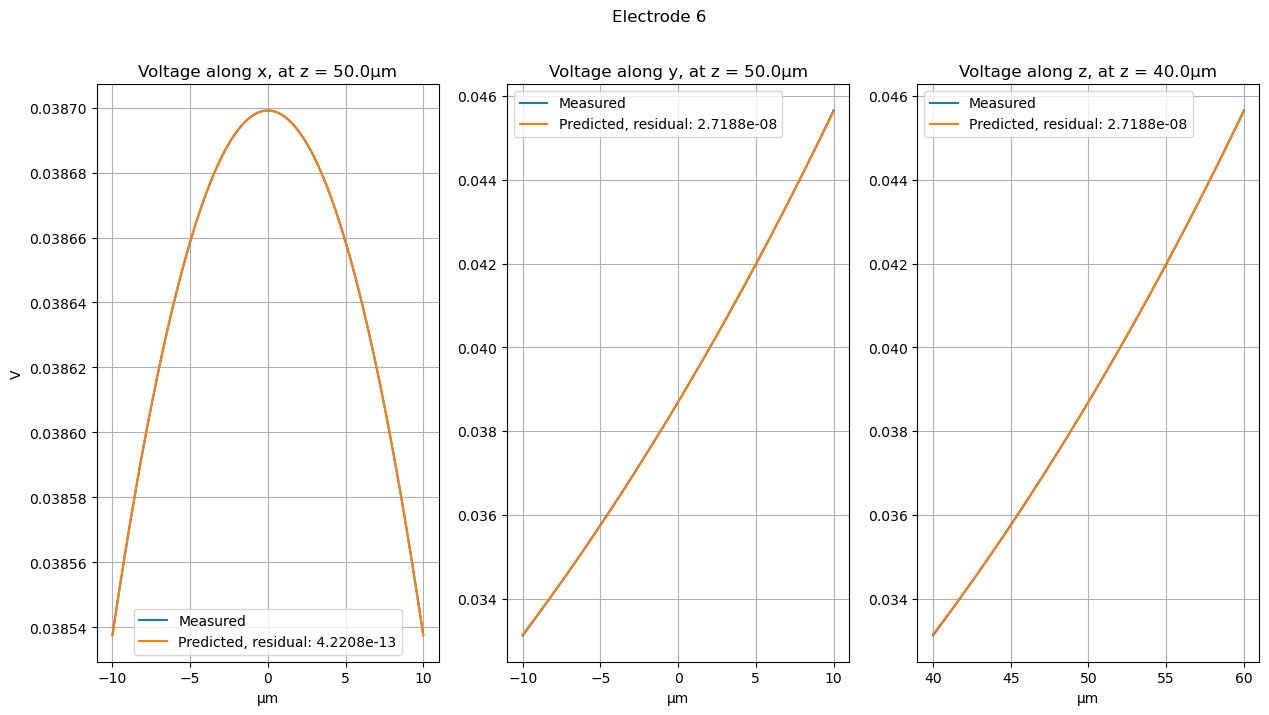

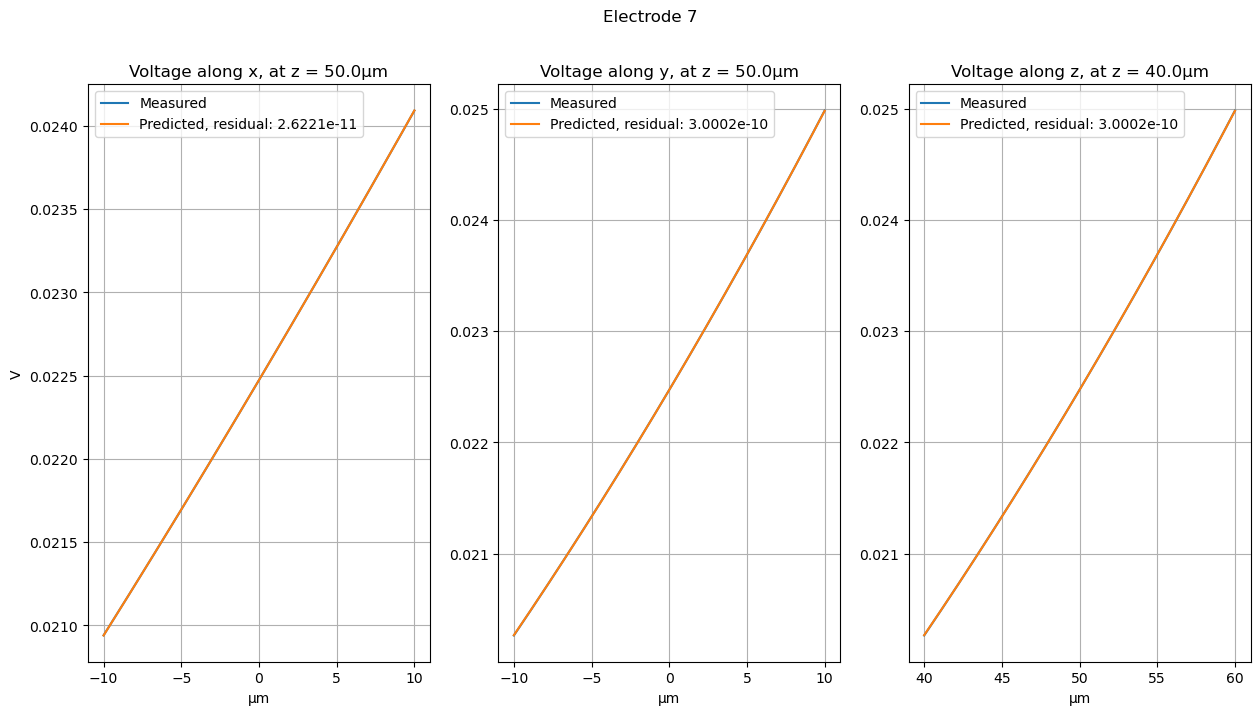

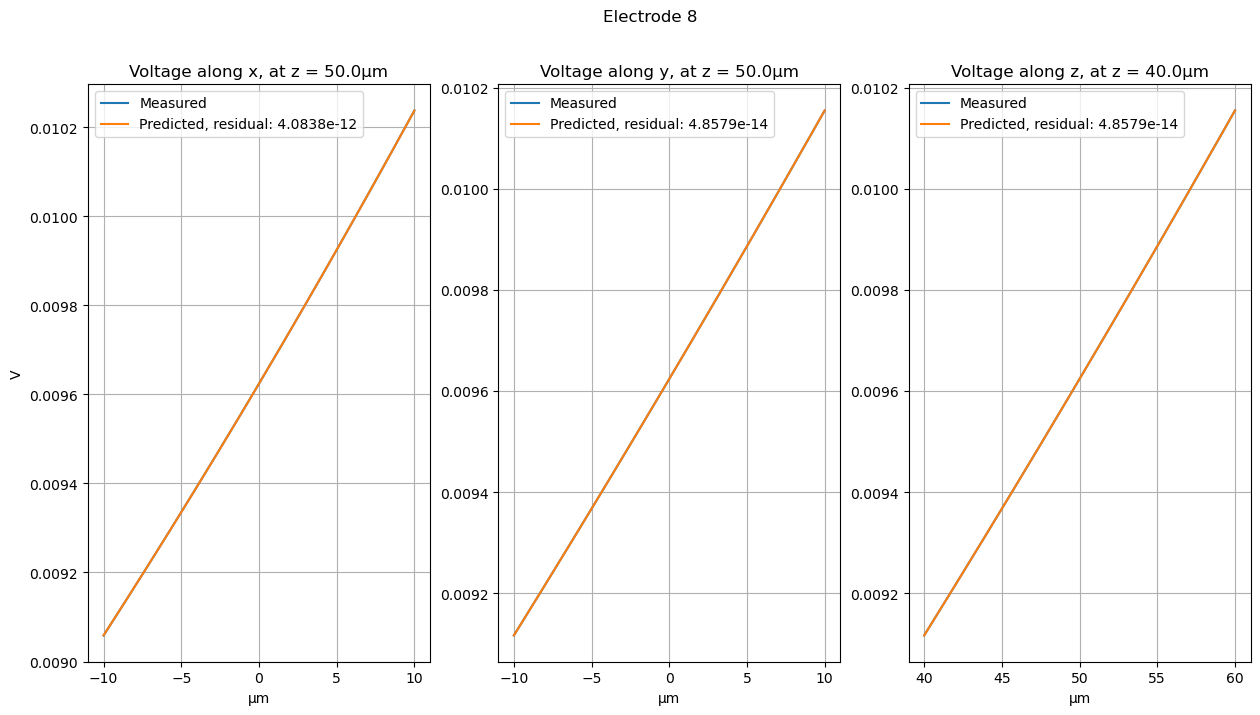

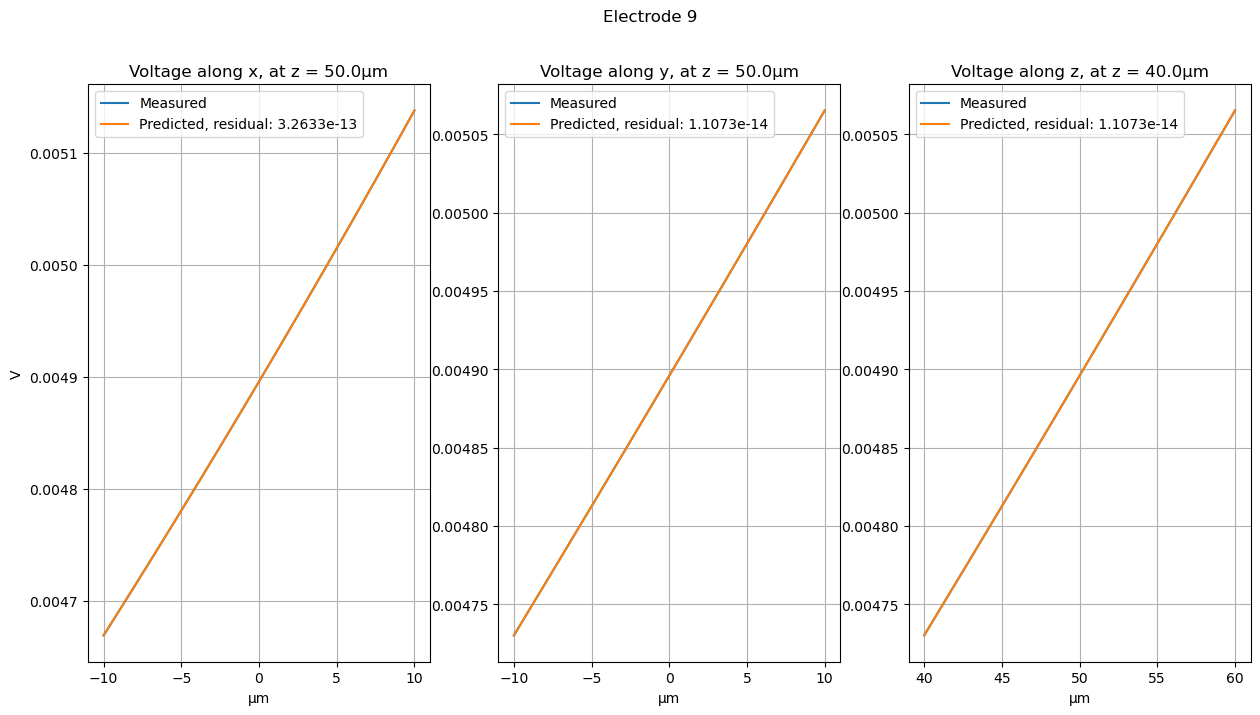

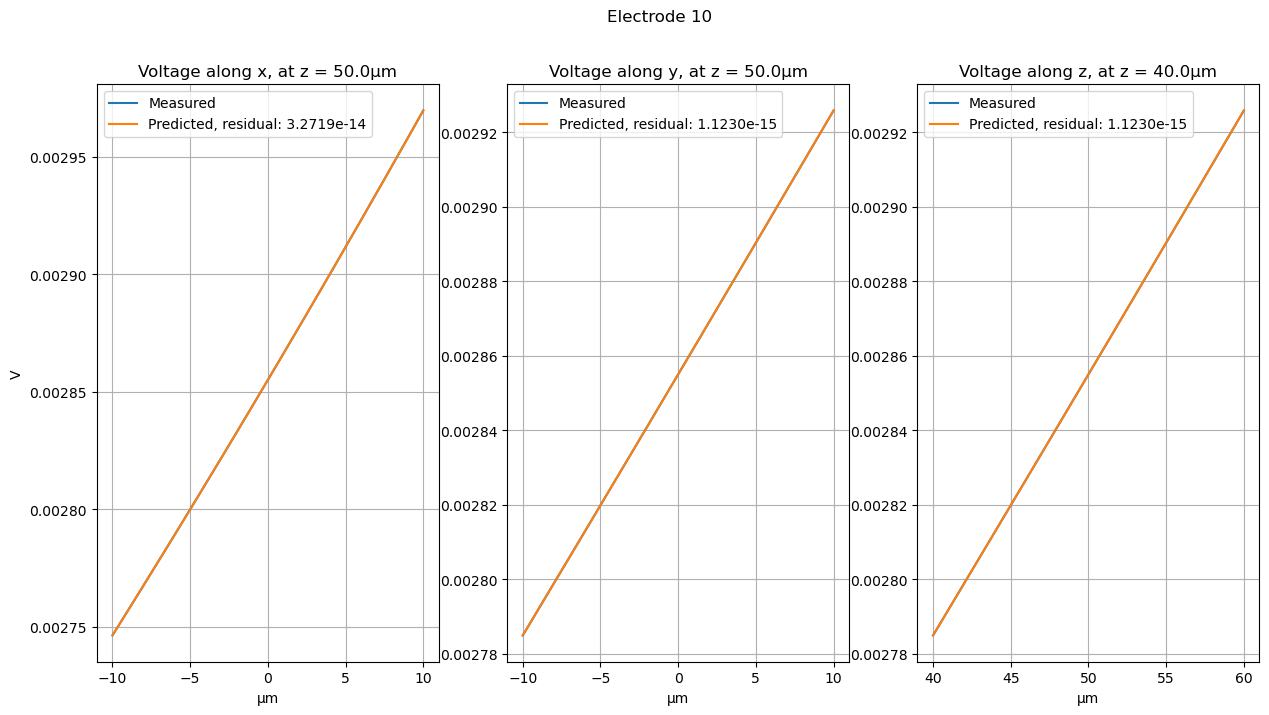

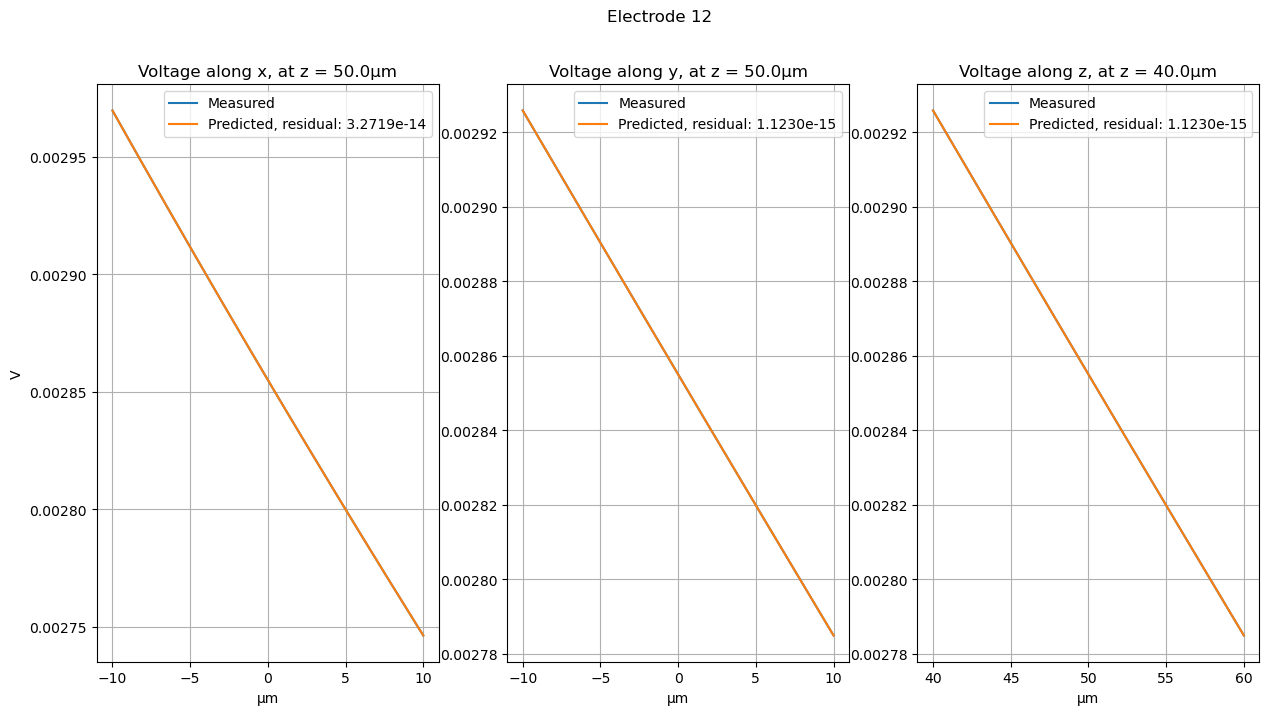

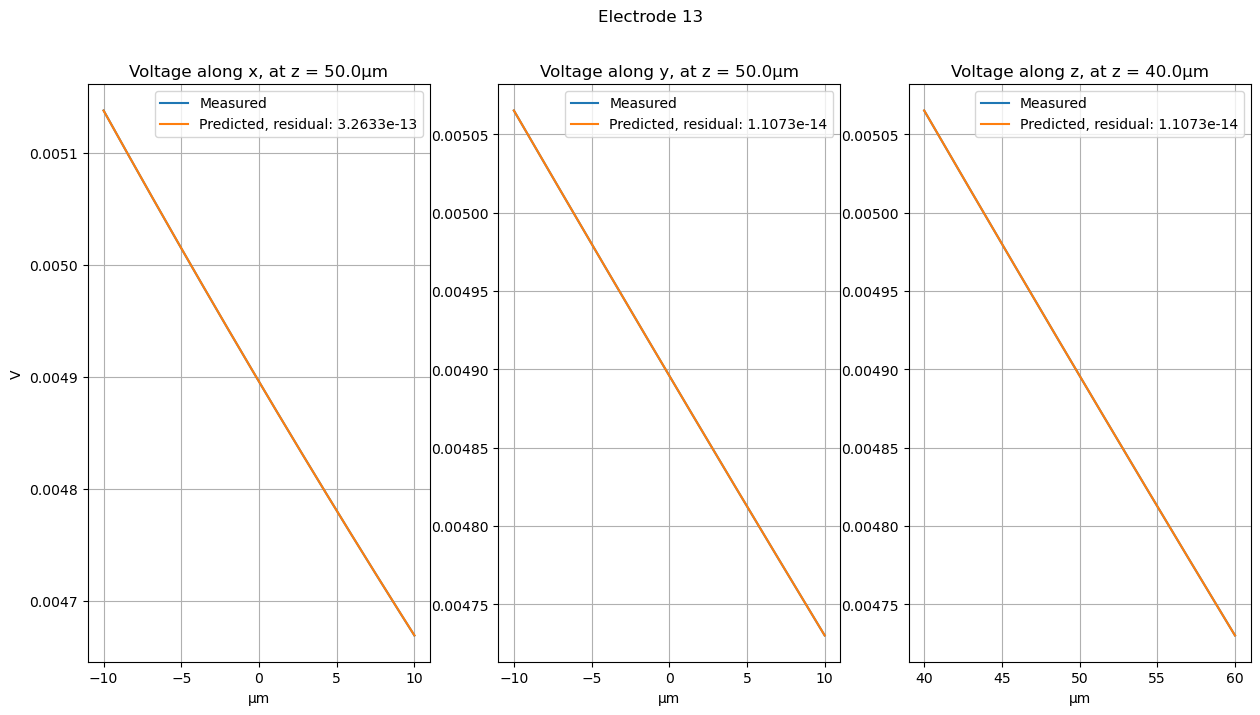

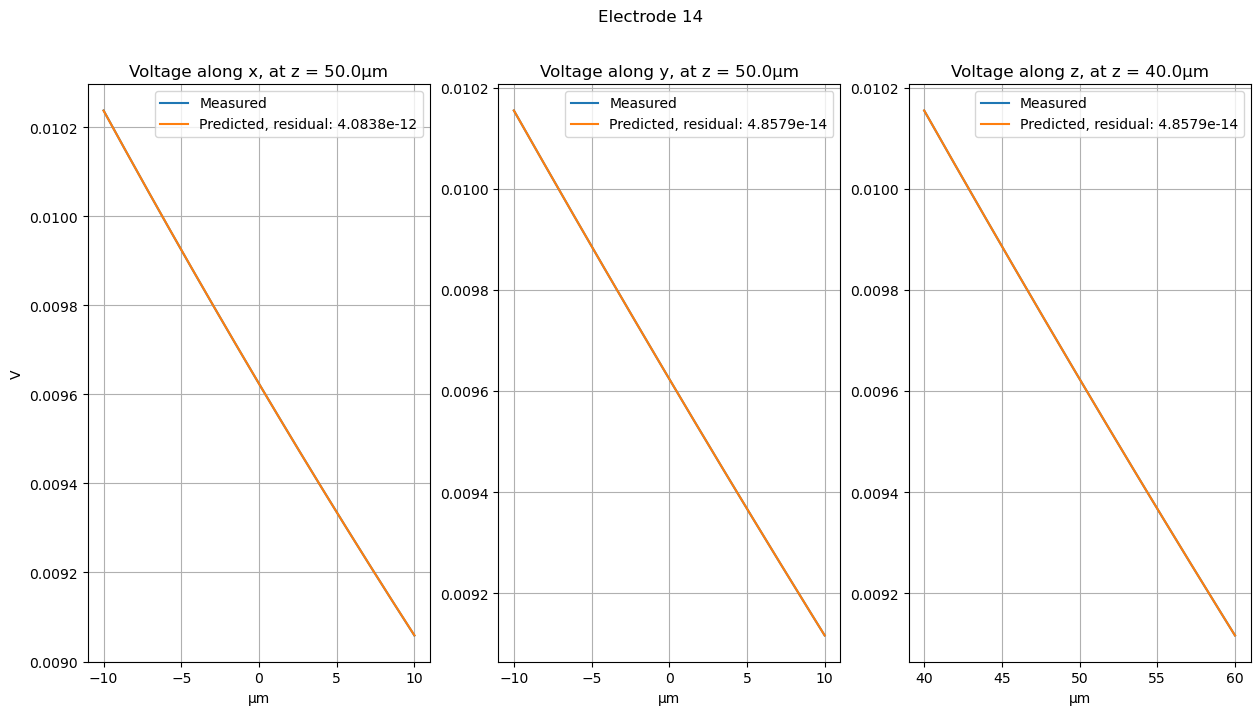

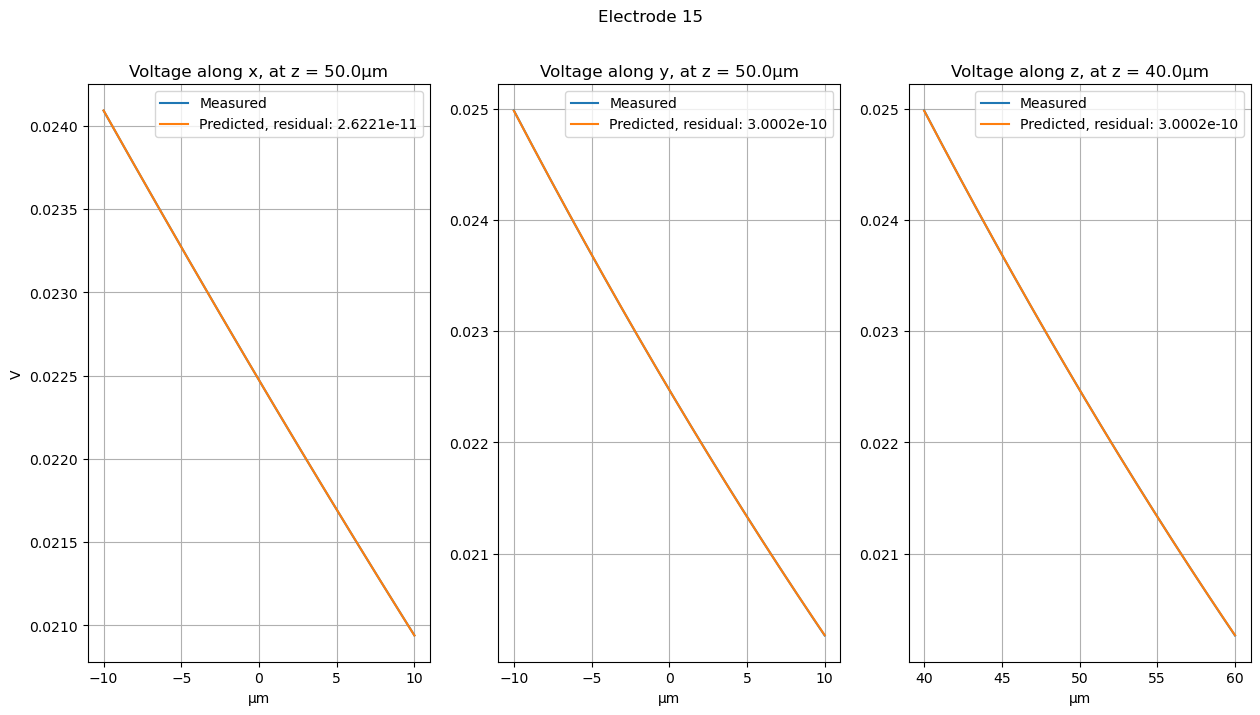

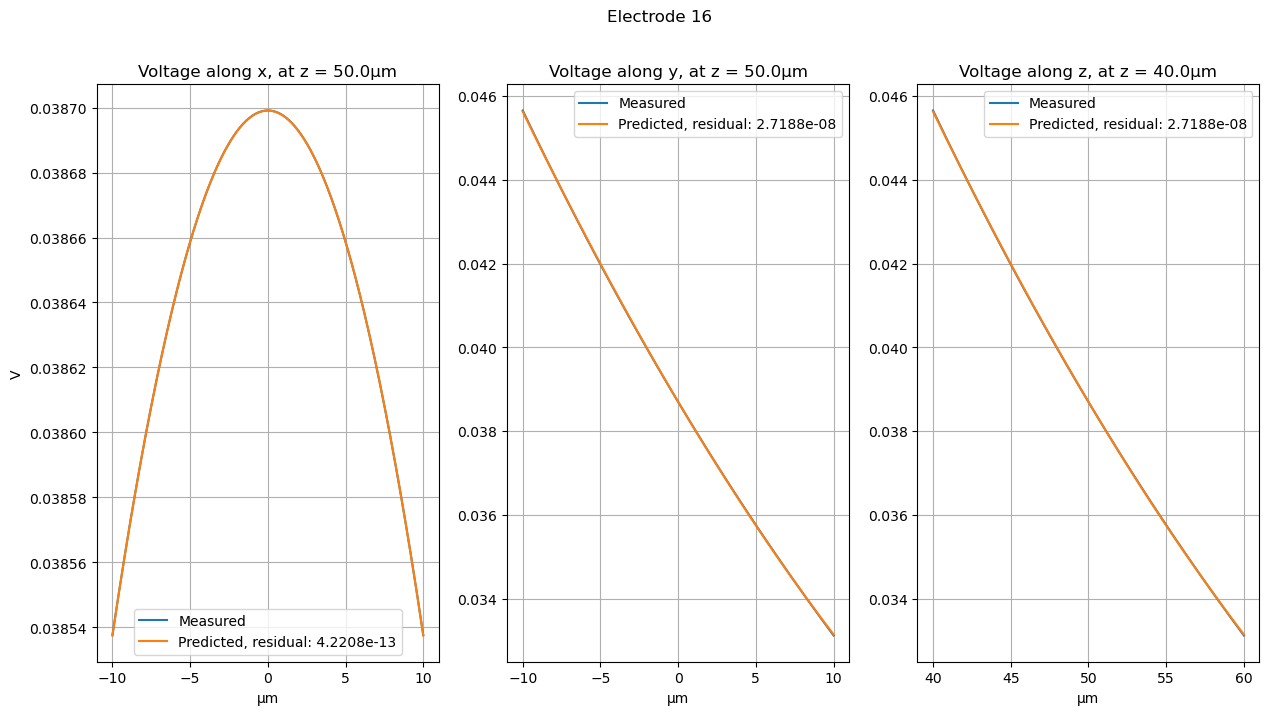

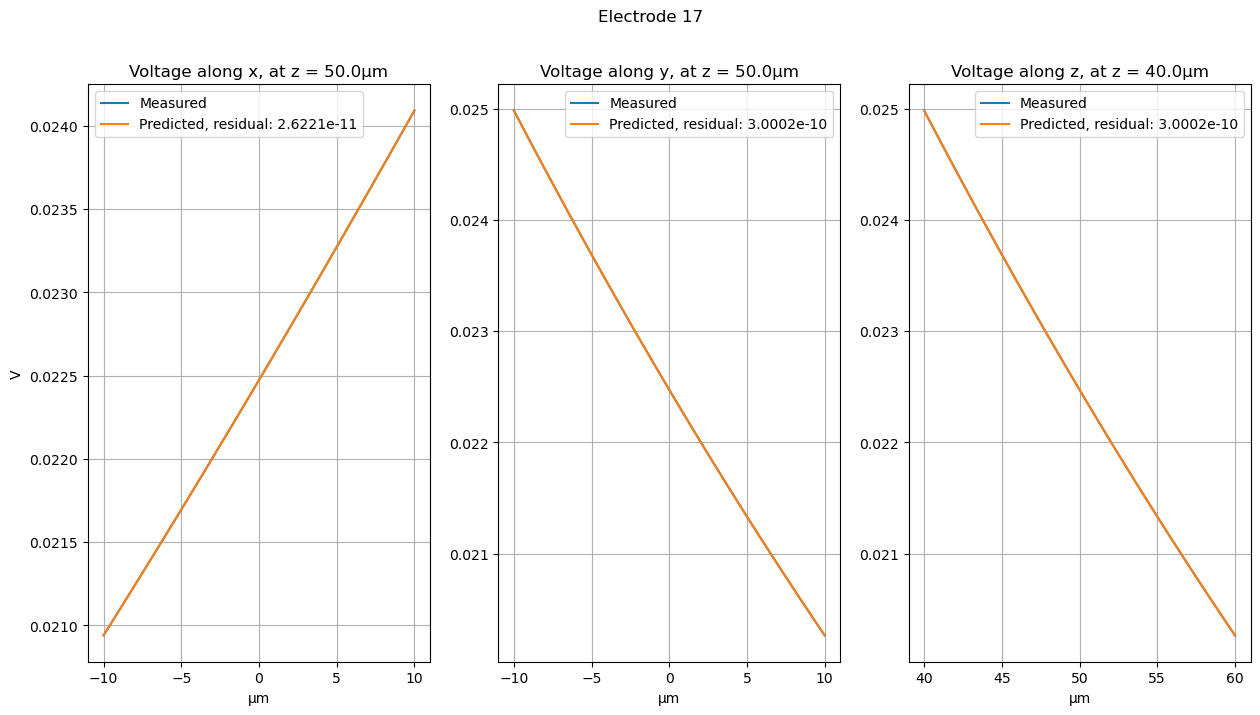

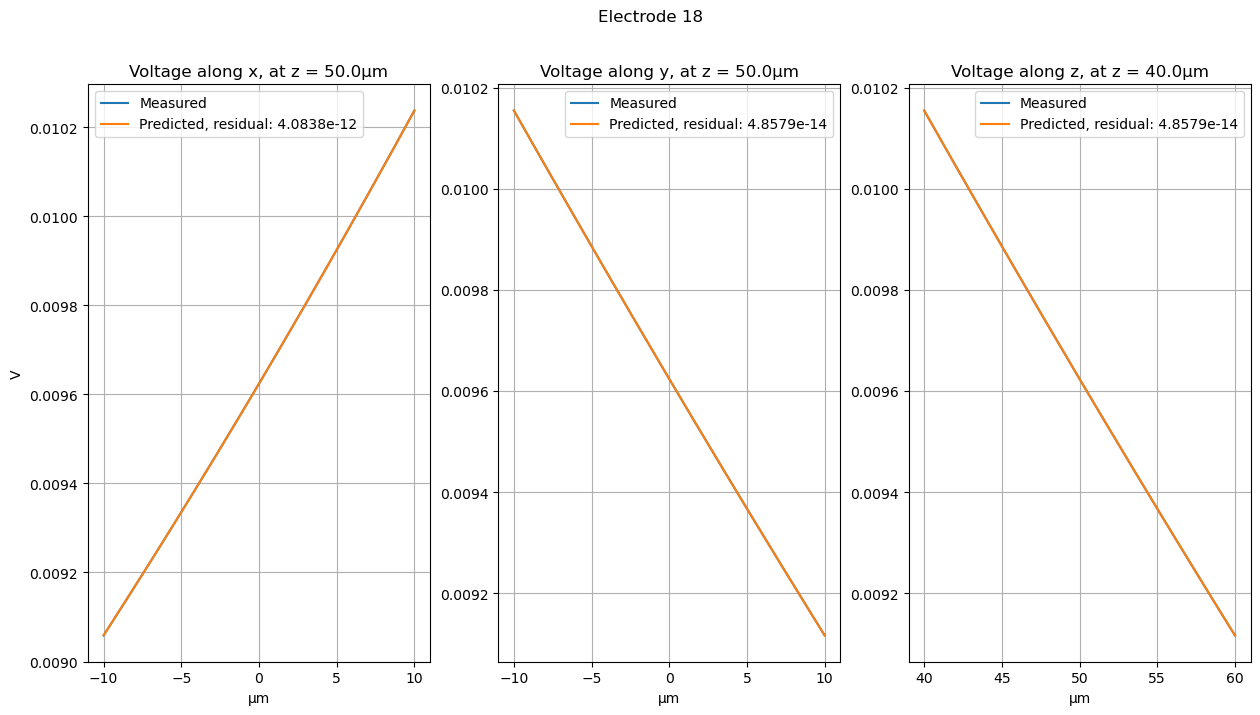

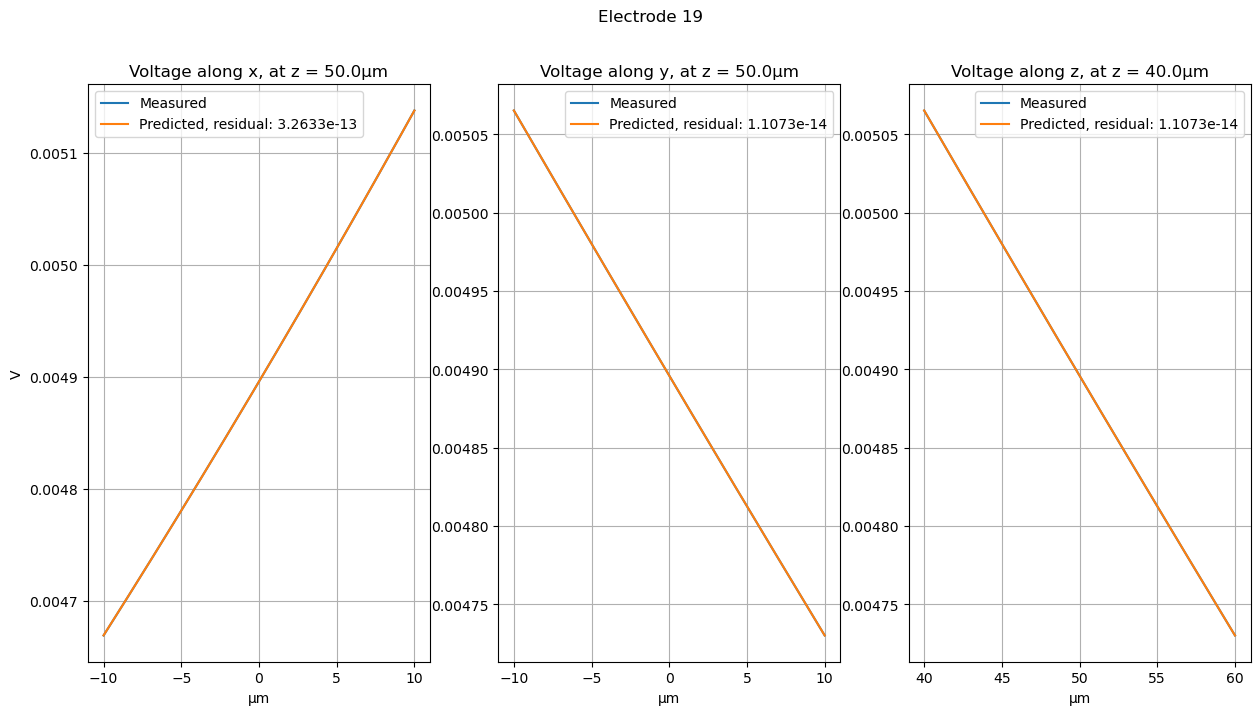

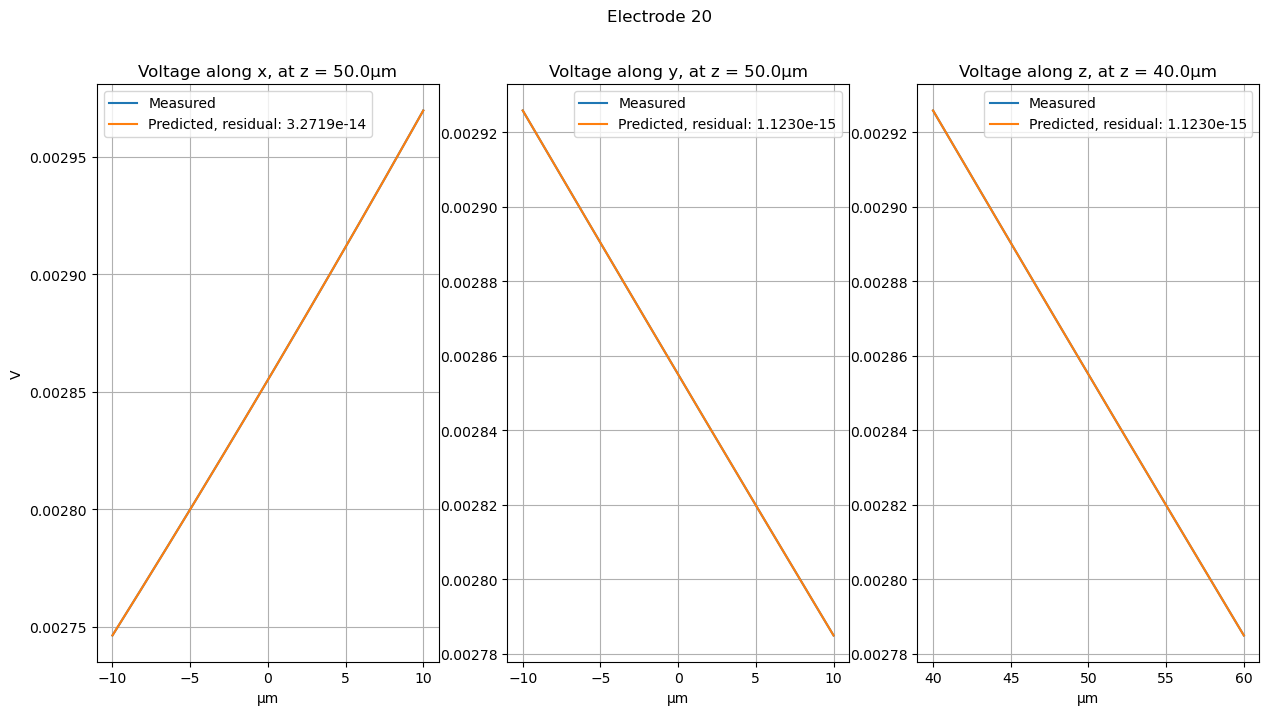

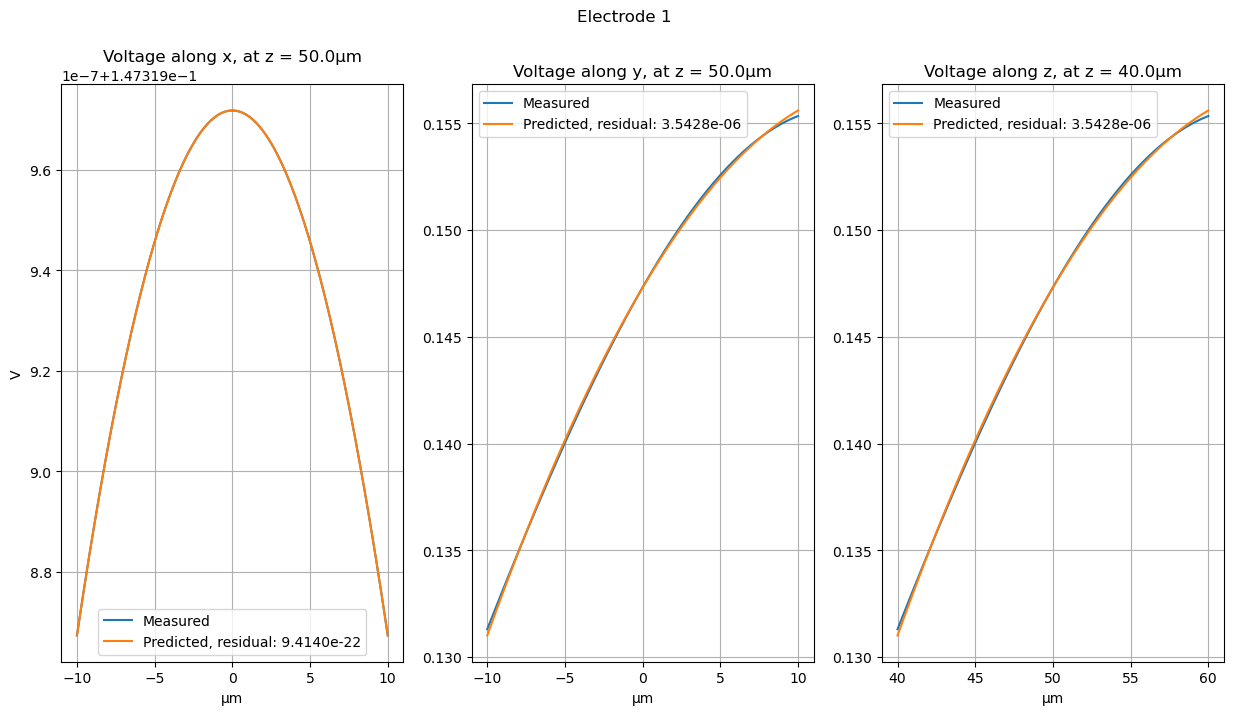

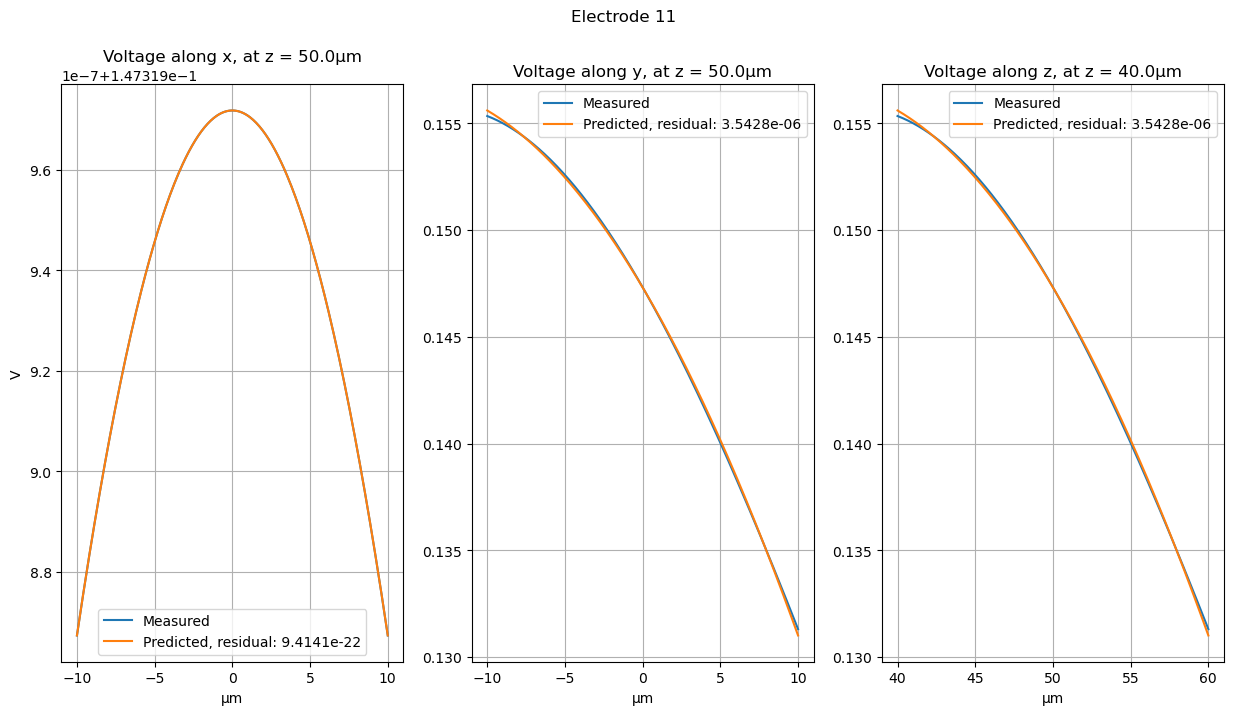

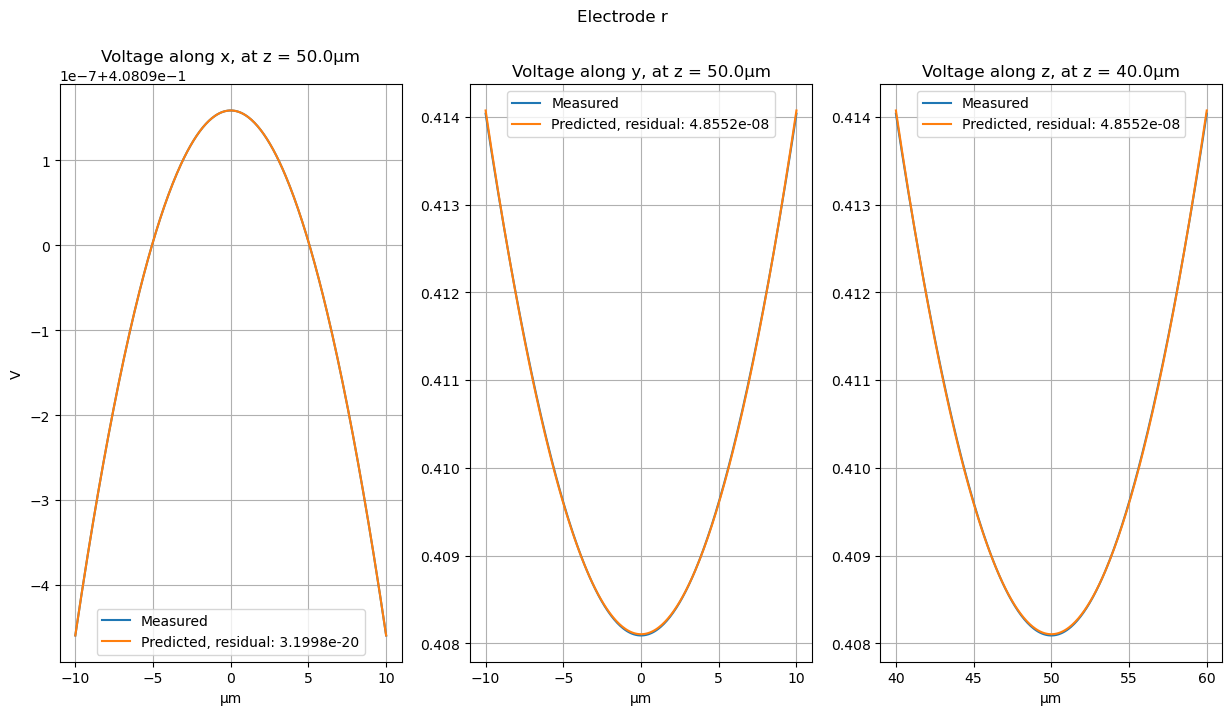

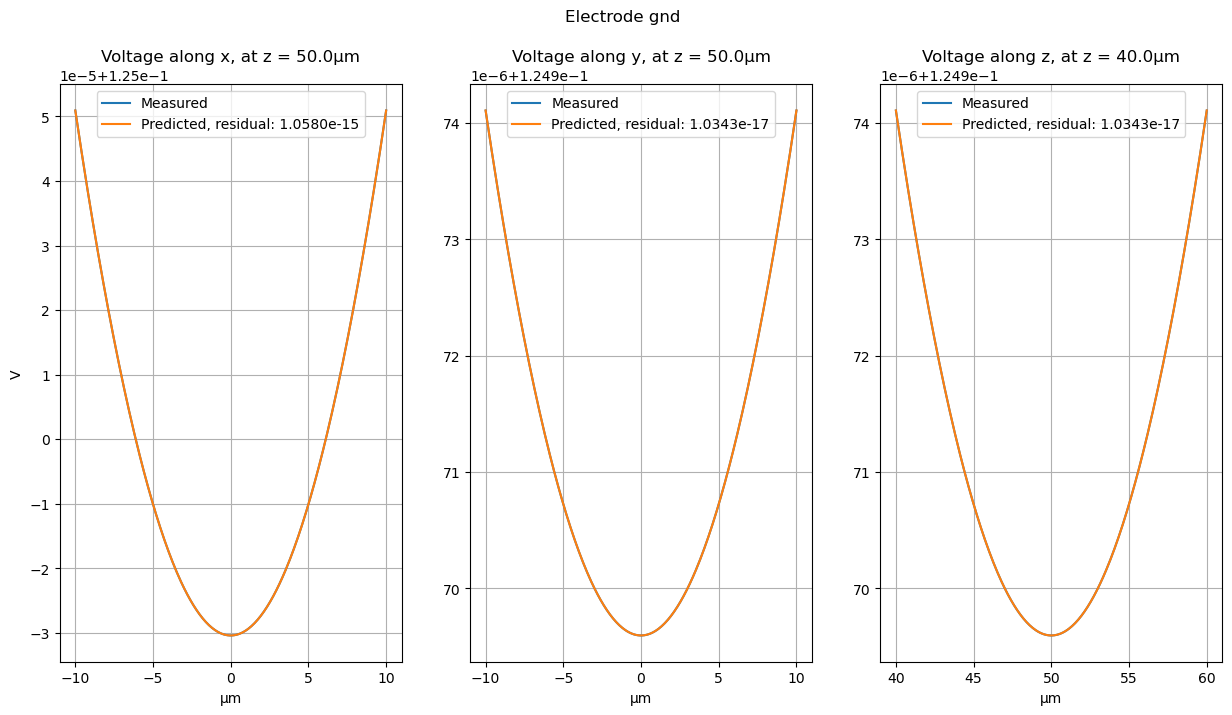

In [151]:
overall_fitted_coeffs = []
overall_residuals = []
# for electrode_num in range(3):
do_plot = True
# axes = {'x': x, 'y': y}
axes = {'x': x, 'y': y, 'z': z}
fit_order = 2
for electrode_num in range(len(s.names)):
    electrode_coeffs = []
    electrode_residuals = []
    # measured = {'x': p_x[electrode_num].flatten(), 'y': p_y[electrode_num].flatten()}
    measured = {'x': p_x[electrode_num].flatten(), 'y': p_y[electrode_num].flatten(), 'z': p_y[electrode_num].flatten()}
    num_axes = len(axes)
    if (do_plot):
        fig_width = 15
        fig, ax = plt.subplots(1, num_axes, figsize=(fig_width, 1/2*fig_width))
        ax = ax.flat
        ax[0].set_ylabel('V')
        electrode_name = s.names[electrode_num]
        fig.suptitle(f'Electrode {electrode_name}')
    for i in range(num_axes):
        ax_name = list(axes.keys())[i]
        ax_coord = list(axes.values())[i][:,i]
        z = list(axes.values())[i][:,2][0]
        # fit
        c_arr, A, residual = solve_axes_coeffs(ax_coord, measured[ax_name], order=fit_order)
        residual_str = np.format_float_scientific(residual, unique=False, precision=4)
        electrode_coeffs.append(c_arr)
        electrode_residuals.append(residual)
        # get predicted result
        predicted = np.dot(A, np.array(c_arr).T)
        if (do_plot):
            # plot numerical solution
            ax[i].set_xlabel('µm')
            ax[i].set_title(f'Voltage along {ax_name}, at z = {z}µm')
            ax[i].plot(ax_coord, measured[ax_name], label='Measured')
            # plot predicted fit
            ax[i].plot(ax_coord, predicted, label=f'Predicted, residual: {residual_str}')
            ax[i].grid()
            ax[i].legend()
    overall_fitted_coeffs.append(np.array(electrode_coeffs).flatten())
    overall_residuals.append(np.array(electrode_residuals))

# generate columns
columns = ['id']
for i in axes:
    for j in range(fit_order+1):
        columns.append('c_'+str(i)+str(j))
for i in axes:
    columns.append('residuals_' + str(i))
# generate pandas csv file
# print(overall_residuals)
savefile = np.concatenate((np.array([s.names]).T, np.array(overall_fitted_coeffs), np.array(overall_residuals)), axis=1)
df = pd.DataFrame(savefile, columns=columns)
df.to_csv(str(datetime.now()) + '_coefficients_quetzal_test_small.csv')
print(columns)


# print(a)

Find the basis voltage set

First try to get the endcap voltages

In [143]:
from scipy.optimize import linprog

In [148]:
A = np.array(overall_fitted_coeffs).T
# delete last two columns of A, corresponding to rf and gnd electrodes
A = np.delete(A, -1, 1)
A = np.delete(A, -1, 1)
# print(A)
# target [c_x0, c_x1, c_x2, c_x0, c_x1, c_x2]
# endcap from Allcock paper
b = np.array([0, 0, -1.02e-6, 0, 0, -1.02e-6])
c = np.ones(len(s.names)-2)
res = linprog(c, A_ub = A, b_ub = b)
# res = linprog(c, A_eq = A, b_eq = b)
print(res)

       message: The problem is infeasible. (HiGHS Status 8: model_status is Infeasible; primal_status is At lower/fixed bound)
       success: False
        status: 2
           fun: None
             x: None
           nit: 0
         lower:  residual: None
                marginals: None
         upper:  residual: None
                marginals: None
         eqlin:  residual: None
                marginals: None
       ineqlin:  residual: None
                marginals: None


In [34]:
print(list({'1': 1}.keys()))
for i in {'1': 1}:
    print (type(i))
# {list(axes.keys())[i]}

['1']
<class 'str'>


In [273]:
z = 50 # height of ion above metal in microns
dz = 2
x_max = 750
y_max = 750
x_b = (-x_max, x_max)
y_b = (-y_max, y_max)
z_b = (z - dz, z + dz)

# gr = (200, 200, 20)
gr = (2250, 2250)
xy, tsx, tsy = make_xy_grid_flat(x_b, y_b, z, grid_res=gr)
# xyz, tsx, tsy, tsz = make_xyz_grid_flat(x_b, y_b, z_b, grid_res=gr)
xyz = np.array(xy)
# print(xyz[:, 0])

High resolution individual electrode run
2250x2250 mesh for 750x750µm^2 gives around 9 meshpoints per µm^2

Fourth order fit without cross terms

In [275]:
def solve_coeffs(potentials, xyz, order=0):
    #want to solve equation f = c + a_x1 * x + a_x2 * x^2 + a_y1 * y + a_y2 * y^2 + a_z1 * z + a_z2 * z^2
    # create matrix of coordinate values
    xyz = np.array(xyz)
    c = np.ones(xyz.shape[0])
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]
    A = np.column_stack([c, x, y, z])

    for p in range(2, order+1):
        A = np.column_stack([A, x**p, y**p, z**p])
    c_arr = []
    # for el_i in range(1):
    for el_i in range(potentials.shape[0]):
        b = potentials[el_i].flatten()
        c, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        print(residuals, rank, s)
        c_arr.append(c)
        print(f'electrode {el_i}:', c)
    return c_arr, A

c_arr = solve_coeffs(pot, xyz, order=4)

[] 9 [2.77234687e+14 1.90181344e+14 3.59249503e+11 3.59249503e+11
 9.64983037e+09 1.07906103e+08 1.07893699e+08 3.89884406e+05
 3.89884405e+05 3.62460105e-04 8.20696781e-06 1.01410359e-07
 1.94493045e-23]
electrode 0: [-5.95564635e-16 -1.70784648e-04  1.22458830e-04  1.70346479e-12
  6.53236944e-07  1.14892535e-07 -1.49345536e-12  2.58385179e-10
 -1.52260840e-10 -7.44457440e-11 -1.20917603e-12 -1.78607143e-13
 -3.72228942e-09]
[] 9 [2.77234687e+14 1.90181344e+14 3.59249503e+11 3.59249503e+11
 9.64983037e+09 1.07906103e+08 1.07893699e+08 3.89884406e+05
 3.89884405e+05 3.62460105e-04 8.20696781e-06 1.01410359e-07
 1.94493045e-23]
electrode 1: [ 1.83863481e-16 -2.27907766e-04  1.24488402e-04  2.29179459e-12
  3.89132079e-07  1.16138442e-07  4.53946466e-13  4.84091487e-10
 -1.54383024e-10  2.29825733e-11 -8.98595028e-13 -1.80484479e-13
  1.14912439e-09]
[] 9 [2.77234687e+14 1.90181344e+14 3.59249503e+11 3.59249503e+11
 9.64983037e+09 1.07906103e+08 1.07893699e+08 3.89884406e+05
 3.89884405

Fourth order fit result plots without cross terms

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_88570/921766671.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots()


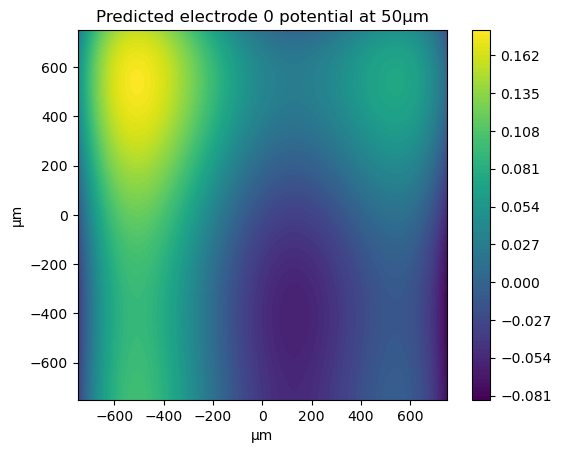

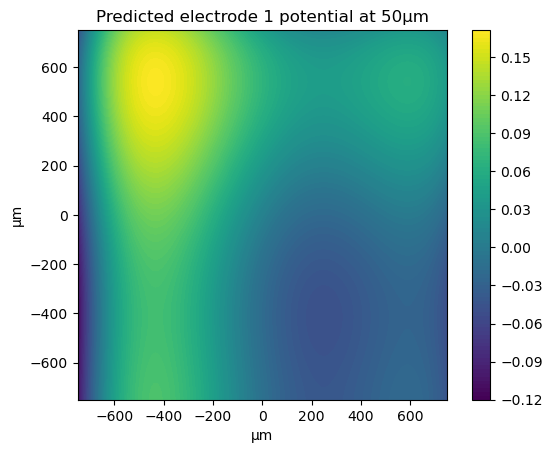

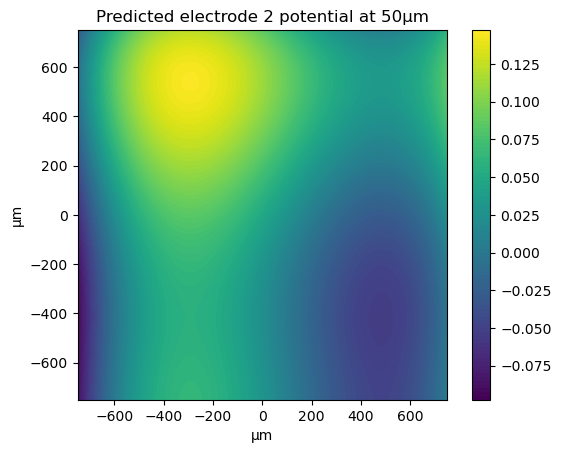

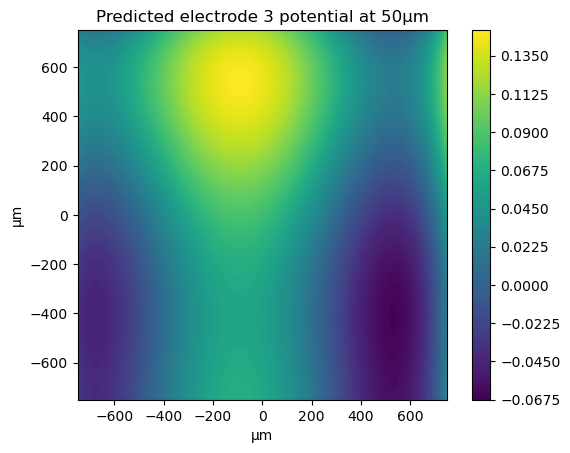

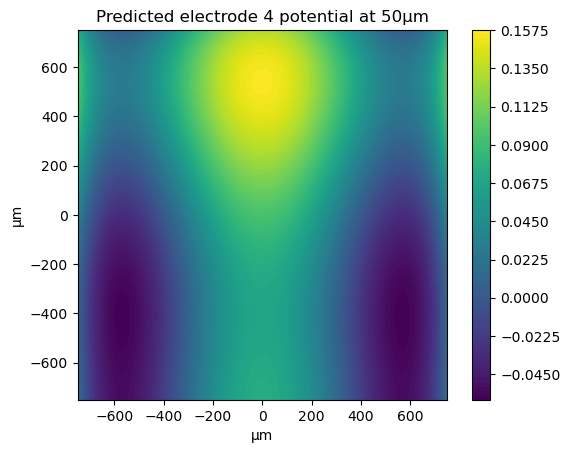

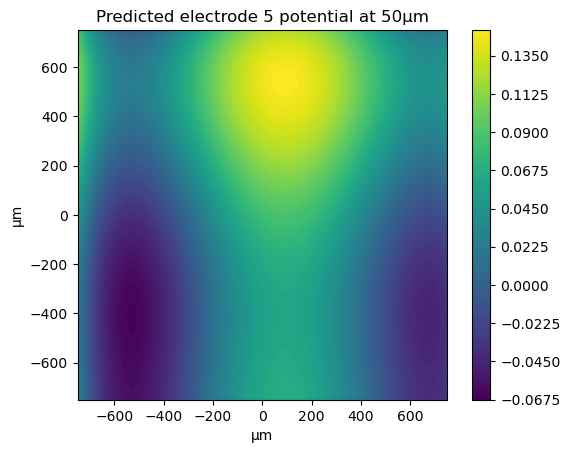

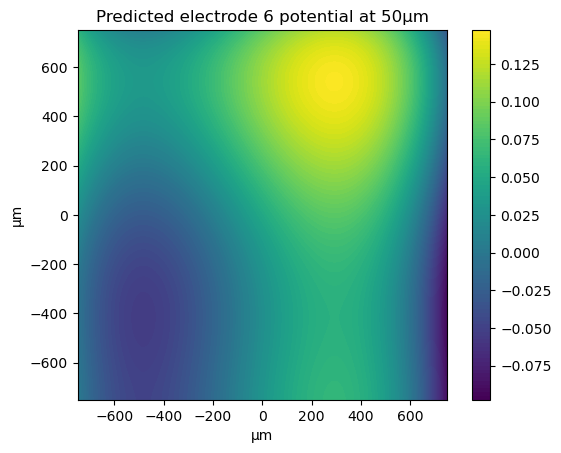

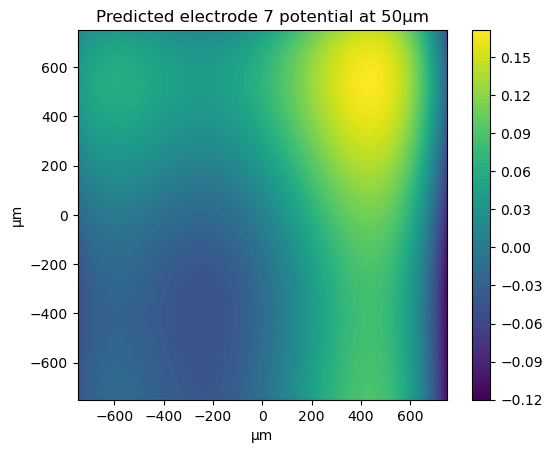

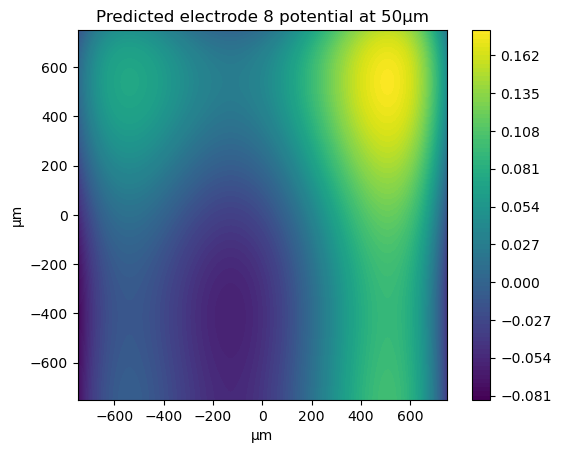

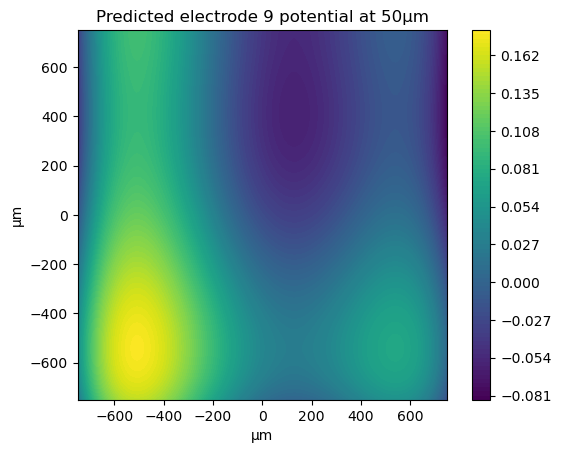

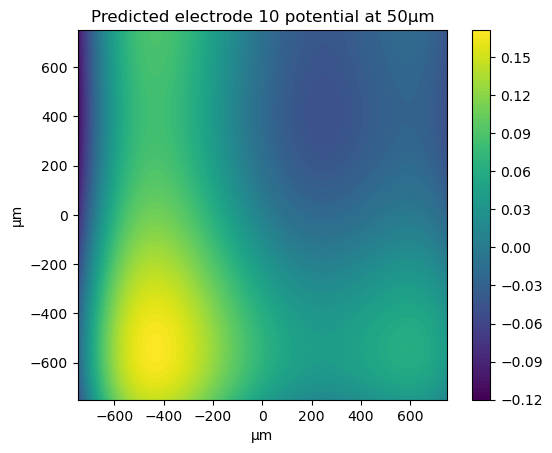

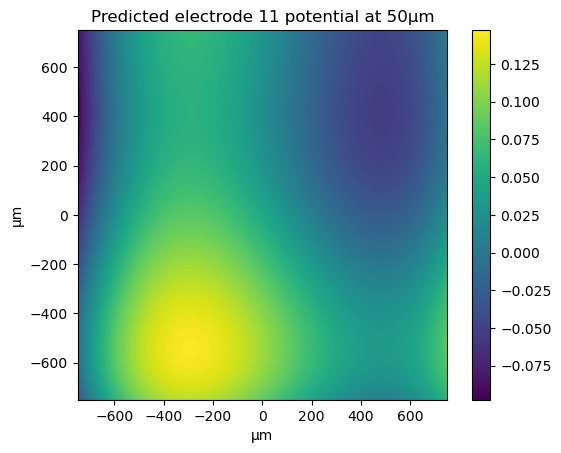

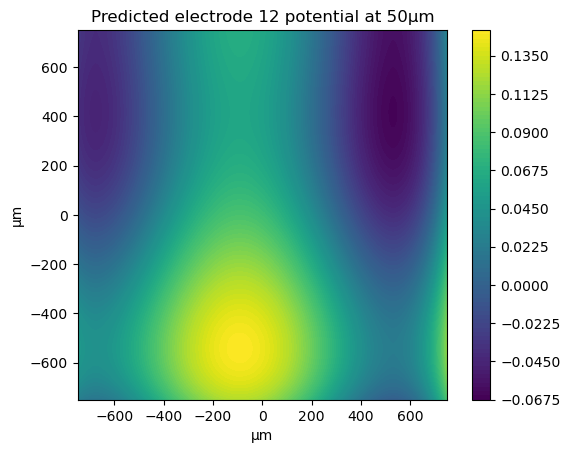

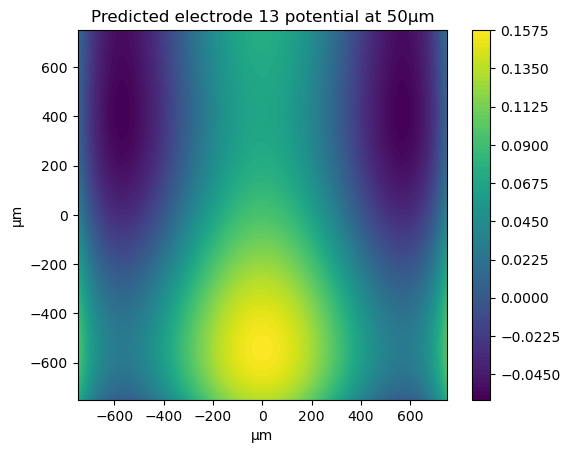

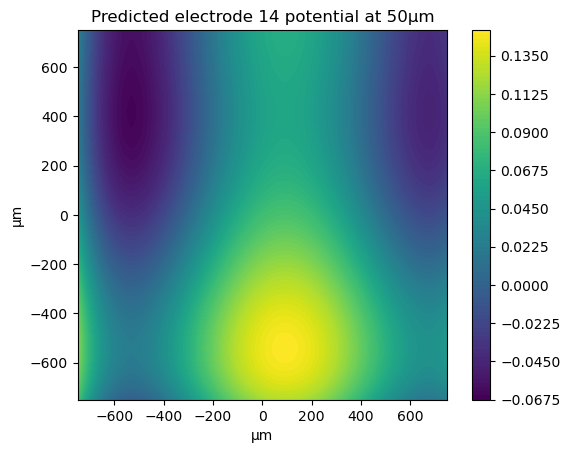

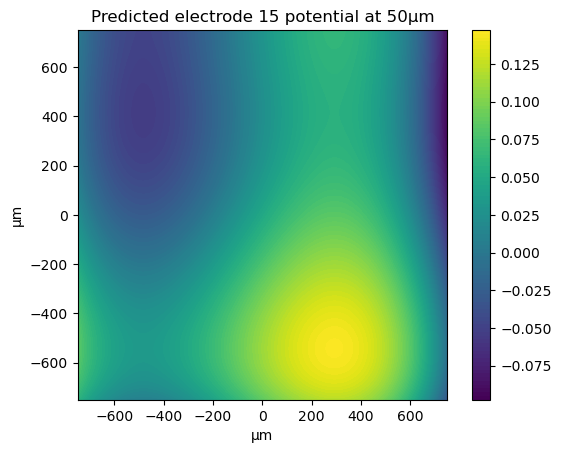

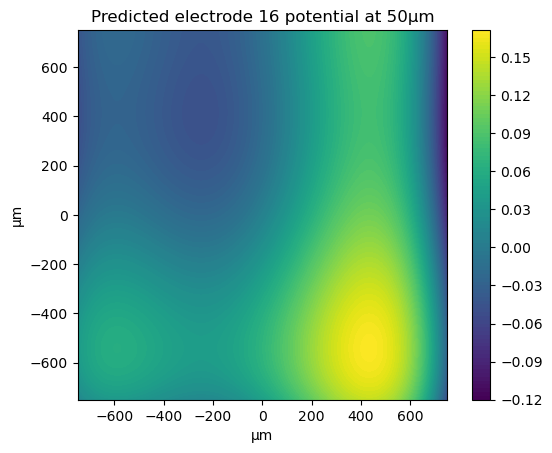

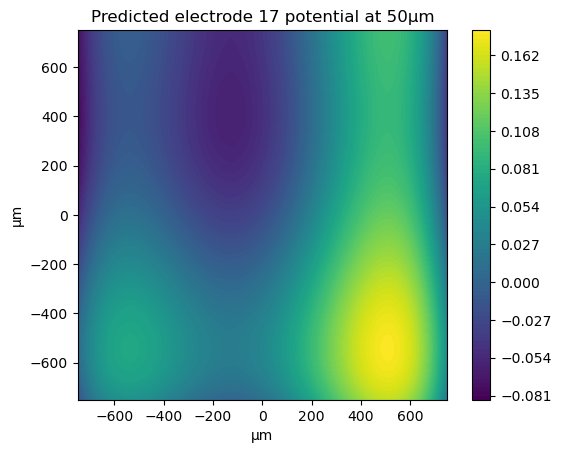

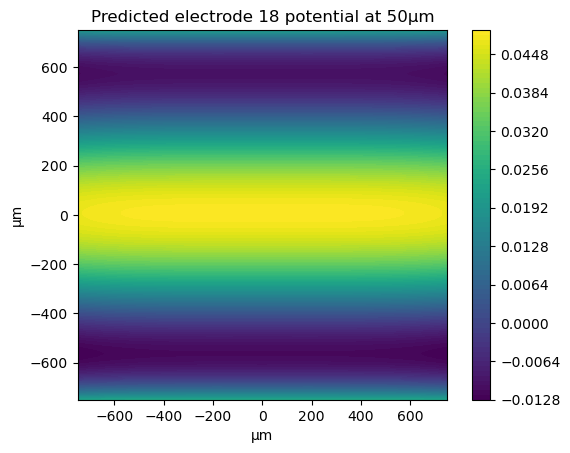

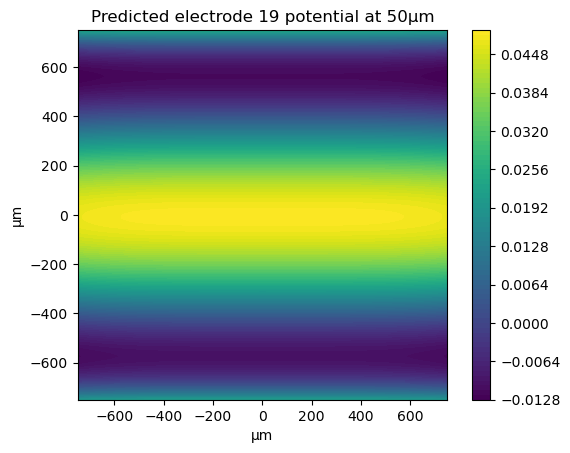

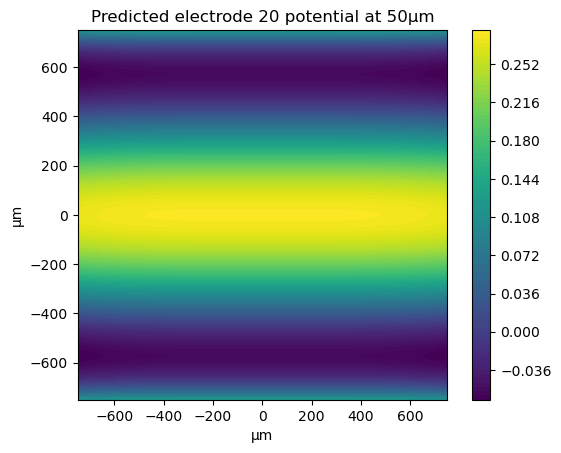

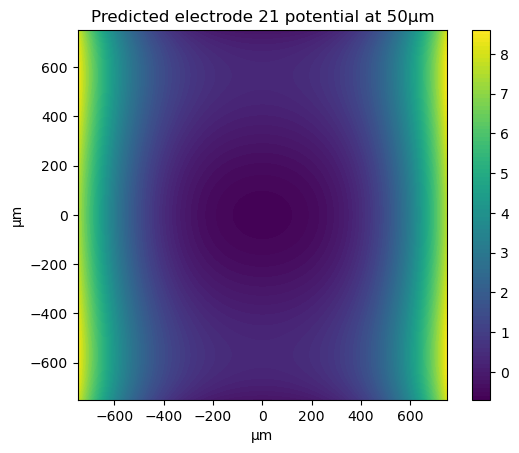

In [278]:
z2 = 50
gr2 = (200, 200)
# gr2 = 100
x_b2 = (-750, -200)
y_b2 = (200, 750)

x_b2 = (-750, 750)
y_b2 = (-750, 750)
xy, tsx2, tsy2 = make_xy_grid_flat(x_b2, y_b2, z2, grid_res=gr2)
xy = np.array(xy)

order = 4
ones = np.ones(xy.shape[0])
A = np.column_stack([ones, xy[:, 0], xy[:, 1], xy[:, 2]])
for p in range(2, order+1):
    A = np.column_stack([A, xy[:, 0]**p, xy[:, 1]**p, xy[:, 2]**p])

# A contains powers of x and y
# c_arr contains coefficients
result = np.dot(A, np.array(c_arr).T)

#electrode i grid potential
for i in range(22):
    grid_potential = np.reshape(result[:, i], gr2)
    fig1, ax1 = plt.subplots()
    ax1.set_aspect('equal')
    ax1.set_title(f'Predicted electrode {i} potential at 50µm')
    ax1.set_xlabel('µm')
    ax1.set_ylabel('µm')
    cf = ax1.contourf(tsx2, tsy2, grid_potential, 100)
    fig1.colorbar(cf)

Fit with crossterms and no z

In [284]:
def solve_coeffs_crossterms(potentials, xyz, order=0):
    #want to solve equation f = c + a_x1 * x + a_x2 * x^2 + a_y1 * y + a_y2 * y^2 + a_z1 * z + a_z2 * z^2
    # create matrix of coordinate values
    xyz = np.array(xyz)
    c = np.ones(xyz.shape[0])
    x = xyz[:, 0]
    y = xyz[:, 1]
    z = xyz[:, 2]
    A = np.column_stack([c, x, y])
    p = 2
    A = np.column_stack([A, x**p, y**p, x*y, x**3, y**3, x*y**2, x**2*y, x**4, y**4])
    # for p in range(2, order+1):
    #     A = np.column_stack([A, x**p, y**p, z**p])
    c_arr = []
    # for el_i in range(1):
    for el_i in range(potentials.shape[0]):
        b = potentials[el_i].flatten()
        c, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        print(residuals, rank, s)
        c_arr.append(c)
        print(f'electrode {el_i}:', c)
    return c_arr

c_arr_cross = solve_coeffs_crossterms(pot, xyz, order=2)

[] 11 [2.77234687e+14 1.90181344e+14 4.04983904e+11 4.04983904e+11
 1.58985442e+11 1.58985442e+11 4.22250167e+08 1.81790109e+08
 1.07906103e+08 3.55914166e+05 3.55914155e+05 9.16175385e+02]
electrode 0: [ 2.64131427e-12 -1.56511302e-04  9.31898081e-05  5.40787348e-07
  2.44294073e-09 -1.83455991e-07  2.58385174e-10 -1.52260840e-10
 -7.60568800e-11  1.55962745e-10 -1.02941634e-12  1.15256112e-15]
[] 11 [2.77234687e+14 1.90181344e+14 4.04983904e+11 4.04983904e+11
 1.58985442e+11 1.58985442e+11 4.22250167e+08 1.81790109e+08
 1.07906103e+08 3.55914166e+05 3.55914155e+05 9.16175385e+02]
electrode 1: [ 2.79971956e-12 -2.17006212e-04  1.42803392e-04  4.23846889e-07
  1.50853254e-07 -1.41074677e-07  4.84091489e-10 -1.54383023e-10
 -5.80899930e-11 -9.75931814e-11 -9.54089428e-13 -2.35978934e-13]
[] 11 [2.77234687e+14 1.90181344e+14 4.04983904e+11 4.04983904e+11
 1.58985442e+11 1.58985442e+11 4.22250167e+08 1.81790109e+08
 1.07906103e+08 3.55914166e+05 3.55914155e+05 9.16175385e+02]
electrode 2:

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_88570/2170671433.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots()


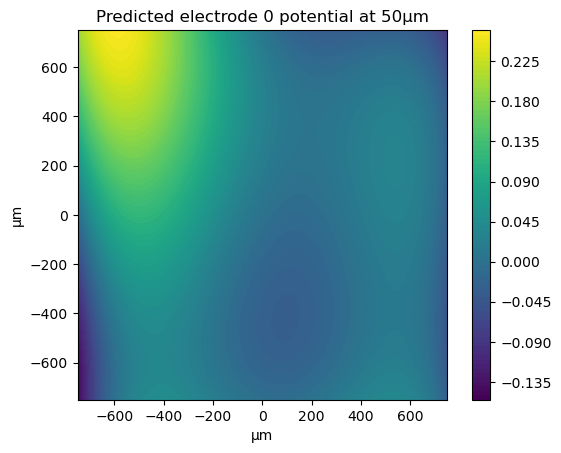

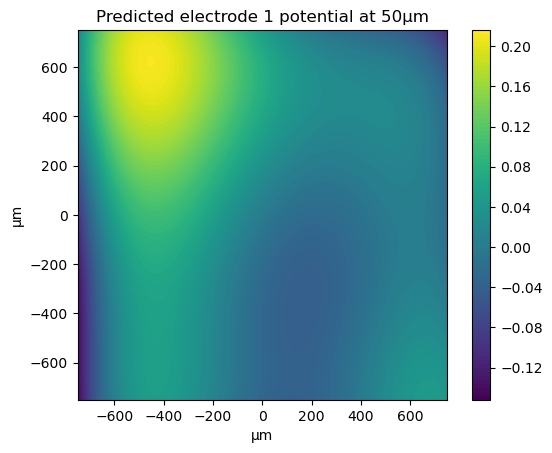

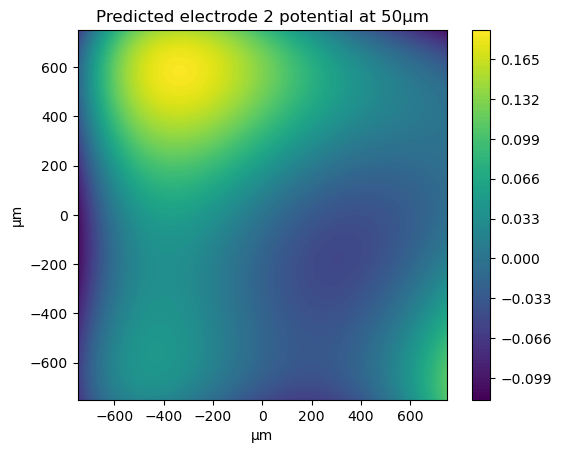

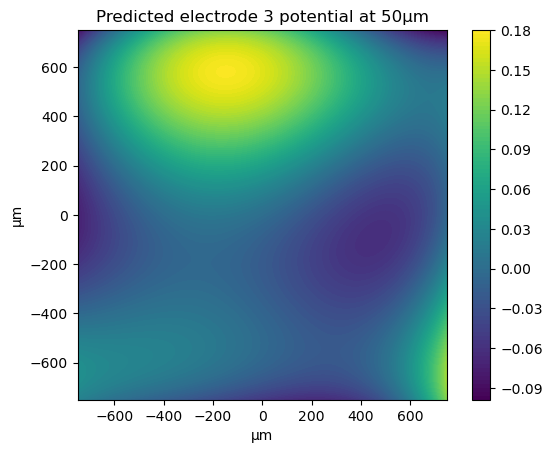

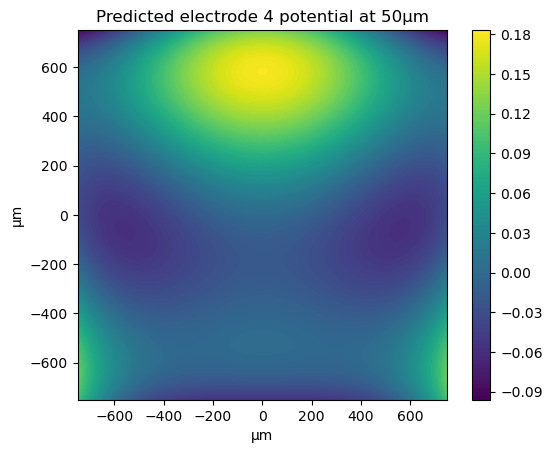

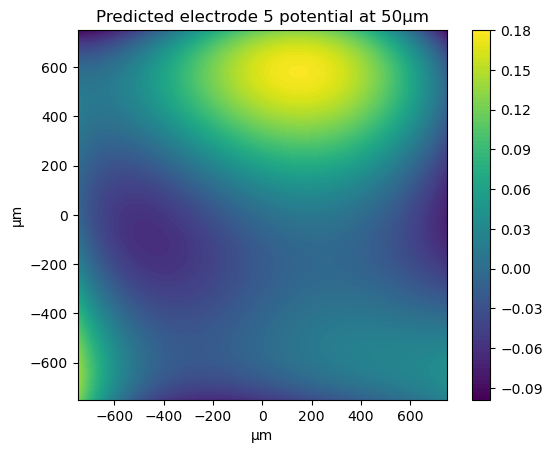

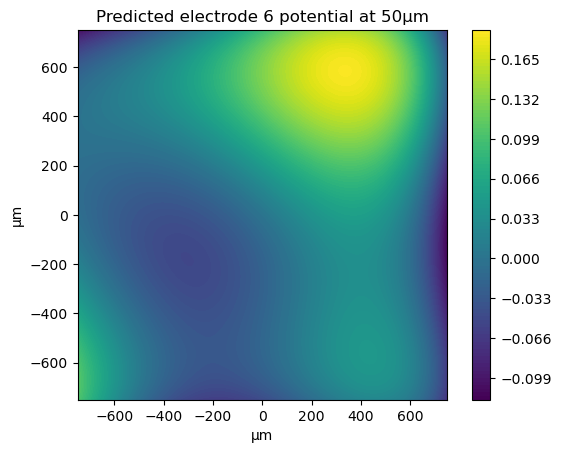

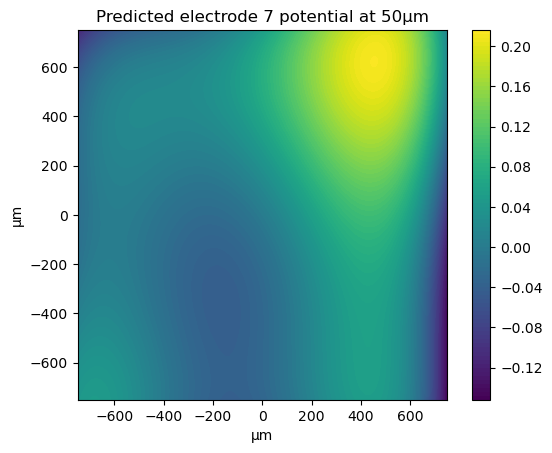

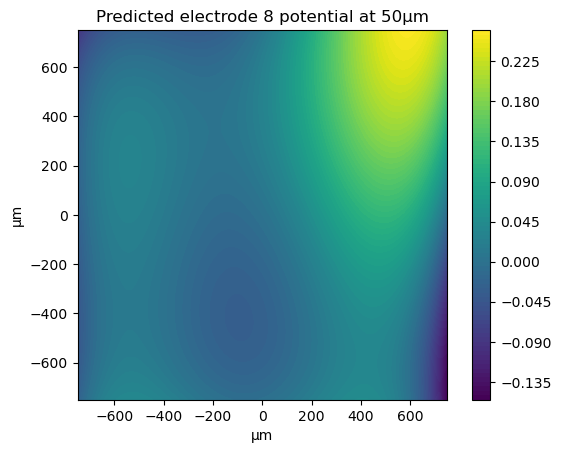

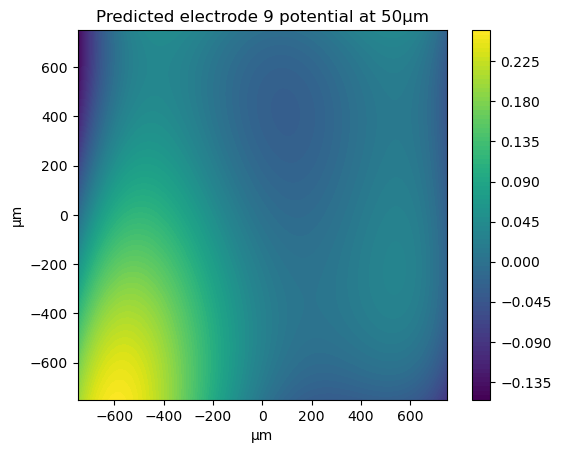

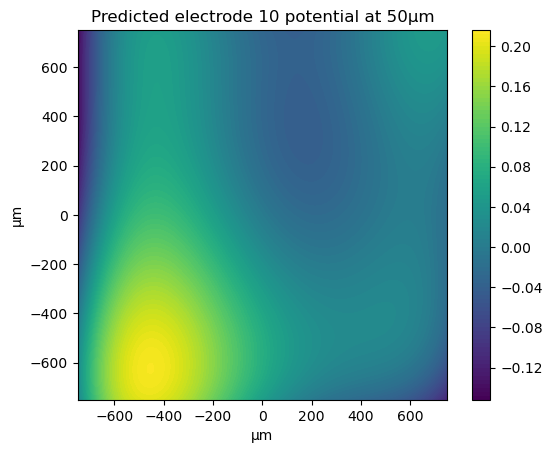

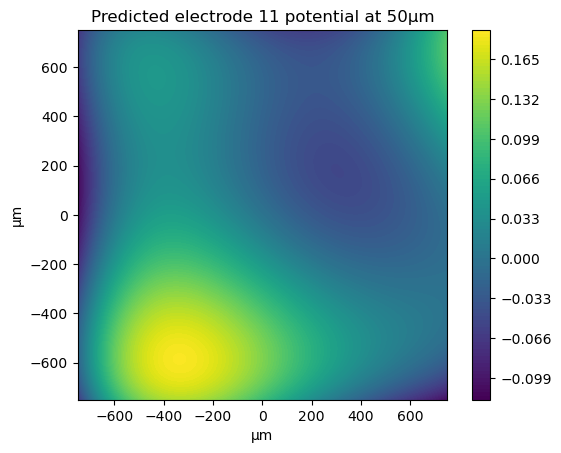

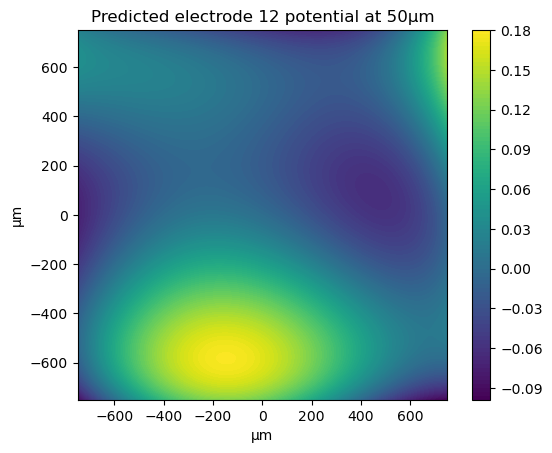

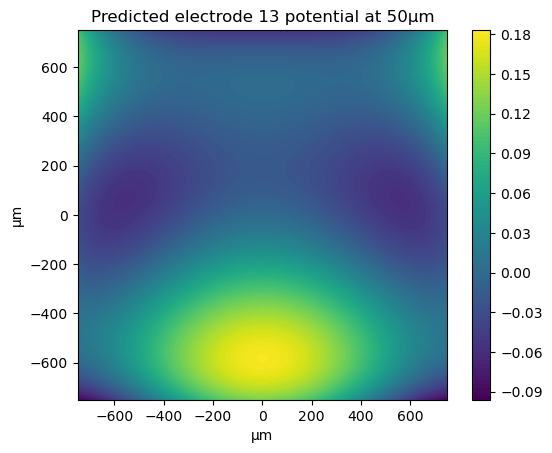

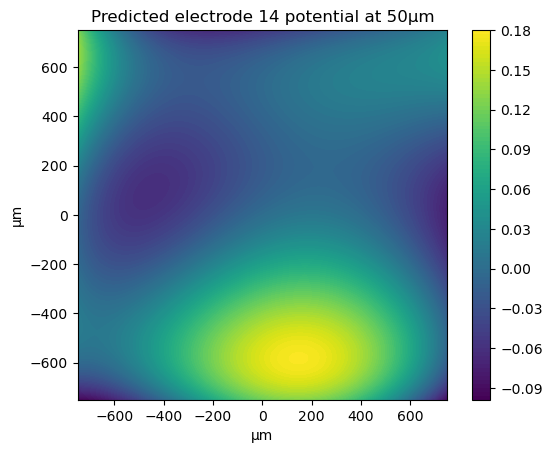

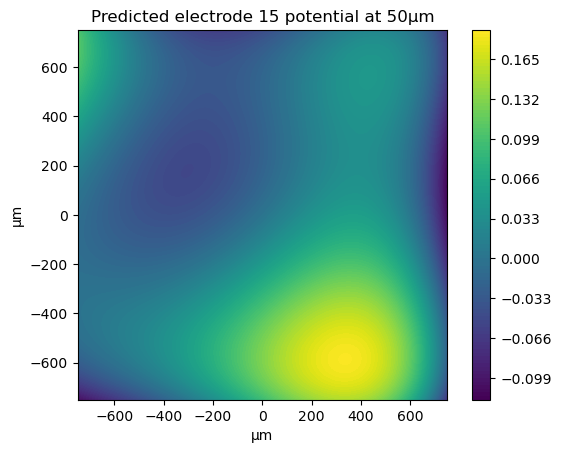

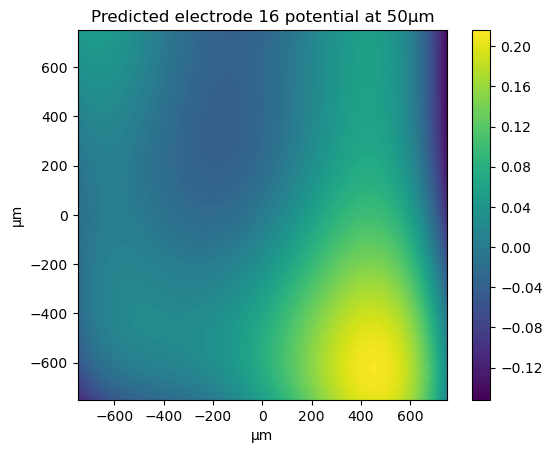

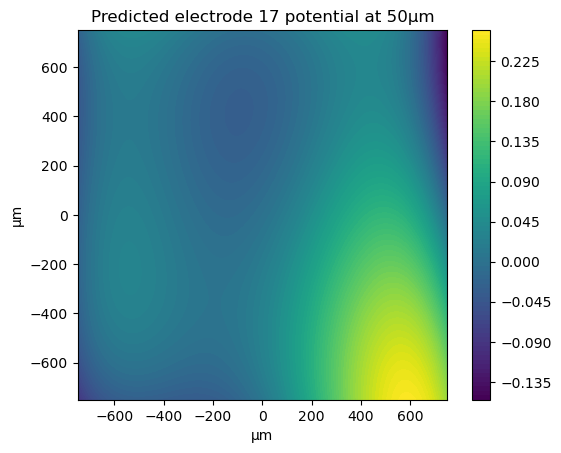

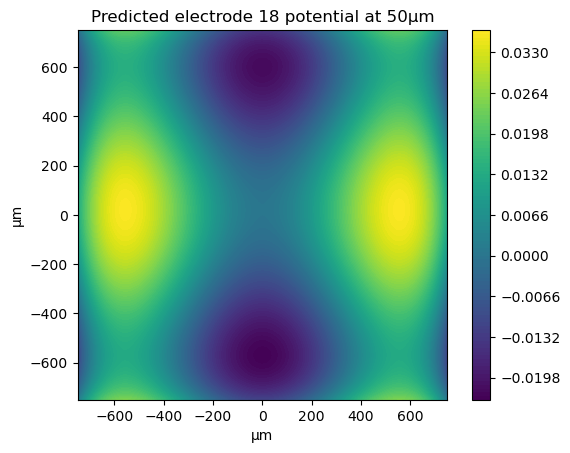

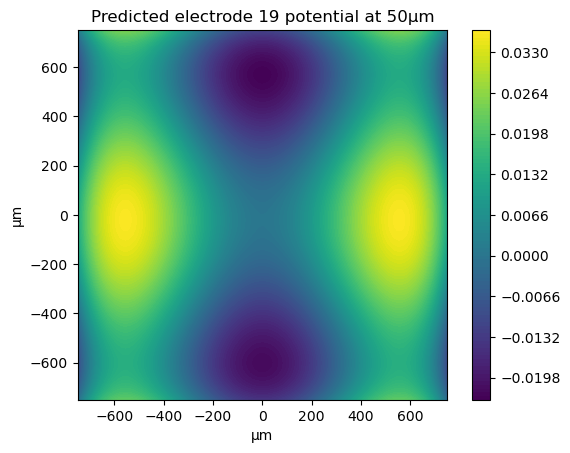

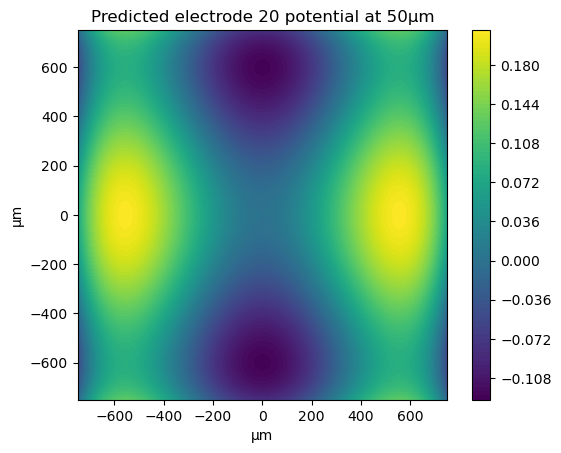

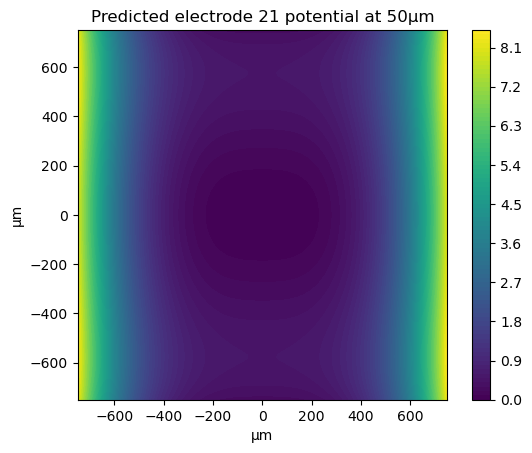

In [285]:
z2 = 50
gr2 = (200, 200)
# gr2 = 100
x_b2 = (-750, -200)
y_b2 = (200, 750)

x_b2 = (-750, 750)
y_b2 = (-750, 750)
xy, tsx2, tsy2 = make_xy_grid_flat(x_b2, y_b2, z2, grid_res=gr2)
xy = np.array(xy)

# order = 4
ones = np.ones(xy.shape[0])
# p = 2
# A = np.column_stack([ones, xy[:, 0], xy[:, 1]])
# for p in range(2, order+1):
# A = np.column_stack([A, xy[:, 0]**p, xy[:, 1]**p, xy[:, 0]*xy[:, 1]])
x = xy[:, 0]
y = xy[:, 1]
z = xy[:, 2]
A = np.column_stack([ones, x, y])
p = 2
A = np.column_stack([A, x**p, y**p, x*y, x**3, y**3, x*y**2, x**2*y, x**4, y**4])

# A contains powers of x and y
# c_arr contains coefficients
result = np.dot(A, np.array(c_arr_cross).T)

#electrode i grid potential
for i in range(22):
    grid_potential = np.reshape(result[:, i], gr2)
    fig1, ax1 = plt.subplots()
    ax1.set_aspect('equal')
    ax1.set_title(f'Predicted electrode {i} potential at 50µm')
    ax1.set_xlabel('µm')
    ax1.set_ylabel('µm')
    cf = ax1.contourf(tsx2, tsy2, grid_potential, 100)
    fig1.colorbar(cf)

In [ ]:
z2 = 50
gr2 = (200, 200)
# gr2 = 100
x_b2 = (-600, -200)
y_b2 = (200, 600)
xy, tsx2, tsy2 = make_xy_grid_flat(x_b2, y_b2, z2, grid_res=gr2)
xy = np.array(xy)

# for i in range (xy.shape[0]):
order = 4
i = 0
ones = np.ones(xy.shape[0])
A = np.column_stack([ones, xy[:, 0], xy[:, 1], xy[:, 2]])
for p in range(2, order+1):
    A = np.column_stack([A, xy[:, 0]**p, xy[:, 0]**p, z**p])
np.
tx = xy[:, 0]
tx2 = tx**2
tx3 = tx**3
tx4 = tx**4

ty = xy[:, 1]
ty2 = ty**2
ty3 = ty**3
ty4 = ty**4

tz = xy[:, 2]
tz2 = tz**2
tz3 = tz**3
tz4 = tz**4
print(c_arr[i])

grid_pot = []
for coord in xy:
    tx = coord[0]
    tx2 = tx**2
    tx3 = tx**3
    tx4 = tx**4

    ty = coord[1]
    ty2 = ty**2
    ty3 = ty**3
    ty4 = ty**4

    tz = coord[2]
    tz2 = tz**2
    tz3 = tz**3
    tz4 = tz**4
    f_pot = c_arr[i][0] + c_arr[i][1] * tx + c_arr[i][2] * tx2 + c_arr[i][3] * tx3 + c_arr[i][4] * tx4 + c_arr[i][5] * ty + c_arr[i][6] * ty2 + c_arr[i][7] * ty3 + + c_arr[i][8] * ty4 + c_arr[i][9] * tz + c_arr[i][10] * tz2 + c_arr[i][11] * tz3 + + c_arr[i][12] * tz4
    grid_pot.append(f_pot)
    # f_pot = c_arr[i][0] + c_arr[i][1] * tx + c_arr[i][2] * tx2 + c_arr[i][3] * tx3 + c_arr[i][4] * tx4 + c_arr[i][5] * ty + c_arr[i][6] * ty2 + c_arr[i][7] * ty3 + + c_arr[i][8] * ty4 + c_arr[i][9] * tz + c_arr[i][10] * tz2 + c_arr[i][11] * tz3 + + c_arr[i][12] * tz4
# grid_potential = np.reshape(f_pot, gr2)
grid_potential = np.reshape(grid_pot, gr2)
# cf = plt.contour(tsx, tsy, potential, 5)
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.set_title(f'Predicted electrode {i} potential at 50µm')
ax1.set_xlabel('µm')
ax1.set_ylabel('µm')
cf = ax1.contourf(tsx2, tsy2, grid_potential, 10)
fig1.colorbar(cf)

In [215]:
    
# 
# def solve_coeffs(potentials, xyz):
#     #want to solve equation f = c + a_x1 * x + a_x2 * x^2 + a_y1 * y + a_y2 * y^2 + a_z1 * z + a_z2 * z^2
#     # create matrix of coordinate values
#     xyz = np.array(xyz)
#     c = np.ones(xyz.shape[0])
#     x = xyz[:, 0]
#     x2 = xyz[:, 0]**2
#     x3 = xyz[:, 0]**3
#     x4 = xyz[:, 0]**4
#     y = xyz[:, 1]
#     y2 = xyz[:, 1]**2
#     y3 = xyz[:, 1]**3
#     y4 = xyz[:, 1]**4
#     z = xyz[:, 2]
#     z2 = xyz[:, 2]**2
#     z3 = xyz[:, 2]**3
#     z4 = xyz[:, 2]**4
#     A = np.column_stack([c, x, x2, x3, x4, y, y2, y3, y4, z, z2, z3, z4])
#     c_arr = []
#     # for el_i in range(1):
#     for el_i in range(potentials.shape[0]):
#         b = potentials[el_i].flatten()
#         c, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
#         print(residuals, rank, s)
#         c_arr.append(c)
#         print(f'electrode {el_i}:', c)
#     return c_arr

# c_arr = solve_coeffs(pot, xyz)

    

[] 7 [2.11932809e+14 1.50725919e+13 3.89479593e+10 4.74894192e+09
 2.74994989e+09 4.54693334e+06 3.00795412e+06 1.15749519e+04
 5.18111615e+02 6.14673915e-03 6.50622985e-19 1.92430289e-20
 1.33195295e-22]
electrode 0: [-3.61085885e-14 -8.60329454e-08  2.75732346e-05  5.90101531e-08
  3.30318188e-11  1.61675059e-07  1.64194018e-05 -7.45443297e-08
  9.33757251e-11 -1.80542942e-12 -9.02714710e-11 -4.51357359e-09
 -2.25678677e-07]
[] 7 [2.11932809e+14 1.50725919e+13 3.89479593e+10 4.74894192e+09
 2.74994989e+09 4.54693334e+06 3.00795412e+06 1.15749519e+04
 5.18111615e+02 6.14673915e-03 6.50622985e-19 1.92430289e-20
 1.33195295e-22]
electrode 1: [-9.92453897e-15 -6.72819321e-08  2.15628925e-05  6.51908888e-08
  5.05516812e-11  1.44200249e-07  1.46446372e-05 -6.66887091e-08
  8.37174280e-11 -4.96226941e-13 -2.48113472e-11 -1.24056739e-09
 -6.20283676e-08]
[] 7 [2.11932809e+14 1.50725919e+13 3.89479593e+10 4.74894192e+09
 2.74994989e+09 4.54693334e+06 3.00795412e+06 1.15749519e+04
 5.18111615

[-3.61085885e-14 -8.60329454e-08  2.75732346e-05  5.90101531e-08
  3.30318188e-11  1.61675059e-07  1.64194018e-05 -7.45443297e-08
  9.33757251e-11 -1.80542942e-12 -9.02714710e-11 -4.51357359e-09
 -2.25678677e-07]


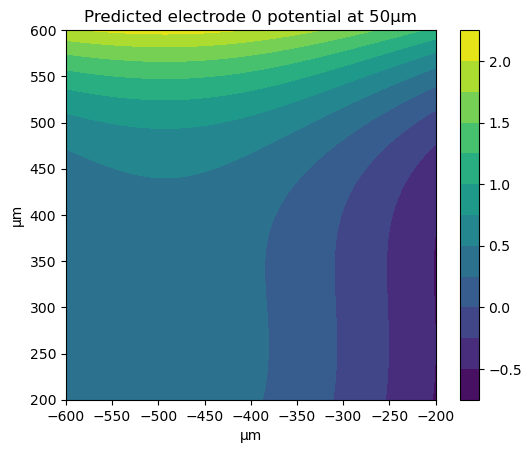

In [220]:
z2 = 50
gr2 = (200, 200)
# gr2 = 100
x_b2 = (-600, -200)
y_b2 = (200, 600)
xy, tsx2, tsy2 = make_xy_grid_flat(x_b2, y_b2, z2, grid_res=gr2)
xy = np.array(xy)

# for i in range (xy.shape[0]):
i = 0
tx = xy[:, 0]
tx2 = tx**2
tx3 = tx**3
tx4 = tx**4

ty = xy[:, 1]
ty2 = ty**2
ty3 = ty**3
ty4 = ty**4

tz = xy[:, 2]
tz2 = tz**2
tz3 = tz**3
tz4 = tz**4
print(c_arr[i])

grid_pot = []
for coord in xy:
    tx = coord[0]
    tx2 = tx**2
    tx3 = tx**3
    tx4 = tx**4

    ty = coord[1]
    ty2 = ty**2
    ty3 = ty**3
    ty4 = ty**4

    tz = coord[2]
    tz2 = tz**2
    tz3 = tz**3
    tz4 = tz**4
    f_pot = c_arr[i][0] + c_arr[i][1] * tx + c_arr[i][2] * tx2 + c_arr[i][3] * tx3 + c_arr[i][4] * tx4 + c_arr[i][5] * ty + c_arr[i][6] * ty2 + c_arr[i][7] * ty3 + + c_arr[i][8] * ty4 + c_arr[i][9] * tz + c_arr[i][10] * tz2 + c_arr[i][11] * tz3 + + c_arr[i][12] * tz4
    grid_pot.append(f_pot)
    # f_pot = c_arr[i][0] + c_arr[i][1] * tx + c_arr[i][2] * tx2 + c_arr[i][3] * tx3 + c_arr[i][4] * tx4 + c_arr[i][5] * ty + c_arr[i][6] * ty2 + c_arr[i][7] * ty3 + + c_arr[i][8] * ty4 + c_arr[i][9] * tz + c_arr[i][10] * tz2 + c_arr[i][11] * tz3 + + c_arr[i][12] * tz4
# grid_potential = np.reshape(f_pot, gr2)
grid_potential = np.reshape(grid_pot, gr2)
# cf = plt.contour(tsx, tsy, potential, 5)
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.set_title(f'Predicted electrode {i} potential at 50µm')
ax1.set_xlabel('µm')
ax1.set_ylabel('µm')
cf = ax1.contourf(tsx2, tsy2, grid_potential, 10)
fig1.colorbar(cf)
# print(tx)
# tz = z*np.ones(xy.shape[0])
# tz2 = xyz[:, 2]**2
# tx = xy[:, 0]
# tx2 = xy[:, 0]**2
# ty = xy[:, 1]
# ty2 = xy[:, 1]**2
# A = np.column_stack([c, x, x2, y, y2, z, z2])
# plt.gca().set_aspect('equal')
# for i in range(len(s.names)):
#     xy_only = np.delete(np.array(xy),2,1)
#     x = xy_only[:, 0]
#     y = xy_only[:, 1]
#     potential = np.reshape(pot[i], (50,50))
#     cf = plt.contour(tsx, tsy, potential, 5)
# plt.colorbar(cf)

In [225]:
def solve_coeffs2(potentials, xyz):
    #want to solve equation f = c + a_x1 * x + a_x2 * x^2 + a_y1 * y + a_y2 * y^2 + a_z1 * z + a_z2 * z^2
    # create matrix of coordinate values
    xyz = np.array(xyz)
    c = np.ones(xyz.shape[0])
    x = xyz[:, 0]
    x2 = xyz[:, 0]**2
    # x3 = xyz[:, 0]**3
    # x4 = xyz[:, 0]**4
    y = xyz[:, 1]
    y2 = xyz[:, 1]**2
    # y3 = xyz[:, 1]**3
    # y4 = xyz[:, 1]**4
    # A = np.column_stack([c, x, x2, x3, x4, y, y2, y3, y4])
    A = np.column_stack([c, x, x2, y, y2])
    c_arr = []
    for el_i in range(1):
    # for el_i in range(potentials.shape[0]):
        b = potentials[el_i].flatten()
        c, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        print(residuals, rank, s)
        c_arr.append(c)
        print(f'electrode {el_i}:', c)
    return c_arr

c_arr2 = solve_coeffs2(pot, xyz)

    

[32116.10113582] 5 [5.84131887e+08 1.03194661e+08 1.86823051e+05 5.54275101e+04
 9.75067674e+01]
electrode 0: [-2.41035333e+00 -1.01605812e-02 -1.01605812e-05  1.70868744e-03
 -2.73305402e-06]


[-3.61085885e-14 -8.60329454e-08  2.75732346e-05  5.90101531e-08
  3.30318188e-11  1.61675059e-07  1.64194018e-05 -7.45443297e-08
  9.33757251e-11 -1.80542942e-12 -9.02714710e-11 -4.51357359e-09
 -2.25678677e-07]


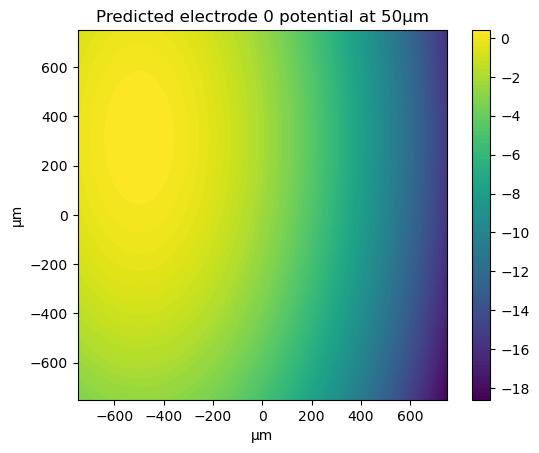

In [232]:
z2 = 50
gr3 = (200, 200)
# gr2 = 100
# x_b2 = (-600, -200)
# y_b2 = (200, 600)
x_b3 = (-x_max, x_max)
y_b3 = (-y_max, y_max)
xy, tsx3, tsy3 = make_xy_grid_flat(x_b3, y_b3, z2, grid_res=gr2)
xy = np.array(xy)

# for i in range (xy.shape[0]):
i = 0
tx = xy[:, 0]
tx2 = tx**2
tx3 = tx**3
tx4 = tx**4

ty = xy[:, 1]
ty2 = ty**2
ty3 = ty**3
ty4 = ty**4

tz = xy[:, 2]
tz2 = tz**2
tz3 = tz**3
tz4 = tz**4
print(c_arr[i])

# grid_pot = []
# for coord in xy:
#     tx = coord[0]
#     tx2 = tx**2
#     tx3 = tx**3
#     tx4 = tx**4

#     ty = coord[1]
#     ty2 = ty**2
#     ty3 = ty**3
#     ty4 = ty**4

#     tz = coord[2]
#     tz2 = tz**2
#     tz3 = tz**3
#     tz4 = tz**4
grid_pot = c_arr2[i][0] + c_arr2[i][1] * tx + c_arr2[i][2] * tx2 + c_arr2[i][3] * ty + c_arr2[i][4] * ty2
    # grid_pot.append(f_pot)
    # f_pot = c_arr[i][0] + c_arr[i][1] * tx + c_arr[i][2] * tx2 + c_arr[i][3] * tx3 + c_arr[i][4] * tx4 + c_arr[i][5] * ty + c_arr[i][6] * ty2 + c_arr[i][7] * ty3 + + c_arr[i][8] * ty4 + c_arr[i][9] * tz + c_arr[i][10] * tz2 + c_arr[i][11] * tz3 + + c_arr[i][12] * tz4
# grid_potential = np.reshape(f_pot, gr2)
grid_potential = np.reshape(grid_pot, gr3)
# cf = plt.contour(tsx, tsy, potential, 5)
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.set_title(f'Predicted electrode {i} potential at 50µm')
ax1.set_xlabel('µm')
ax1.set_ylabel('µm')
cf = ax1.contourf(tsx3, tsy3, grid_potential, 100)
fig1.colorbar(cf)

TypeError: Length of x (100) must match number of columns in z (50)

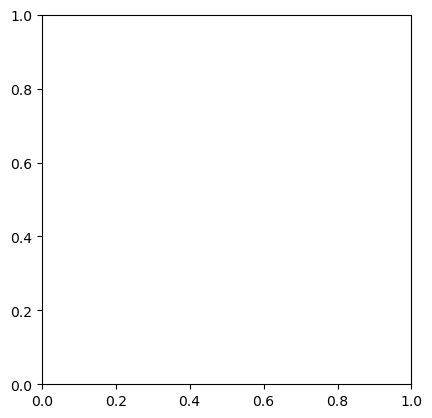

In [122]:
# fig1, ax1 = plt.subplots()
plt.gca().set_aspect('equal')
for i in range(len(s.names)):
    xy_only = np.delete(np.array(xy),2,1)
    # x = xy_only[:, 0]
    # y = xy_only[:, 1]
    potential = np.reshape(pot[i], (50,50))
    cf = plt.contour(tsx, tsy, potential, 5)
plt.colorbar(cf)

/var/folders/06/7pjfbw510cz2ch1m7lx8vvl80000gn/T/ipykernel_88570/2994003090.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots()


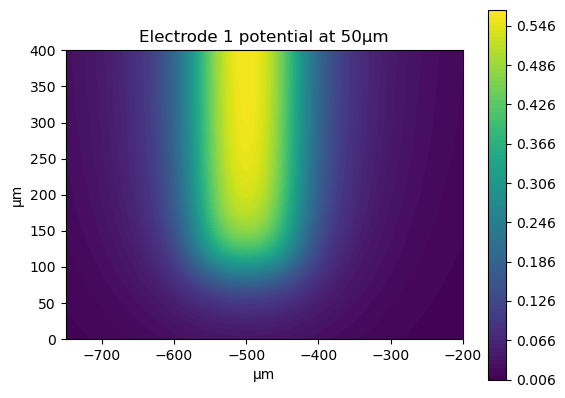

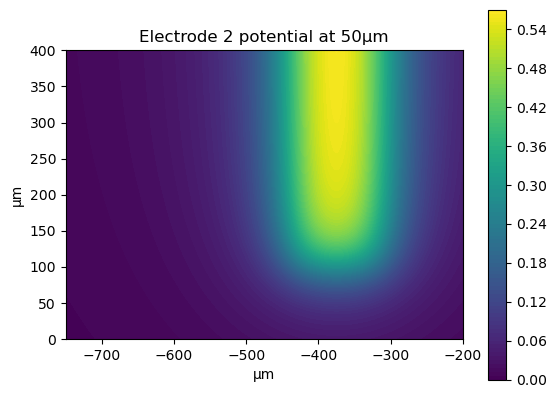

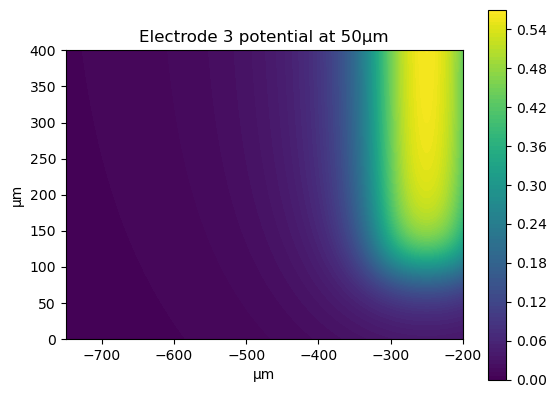

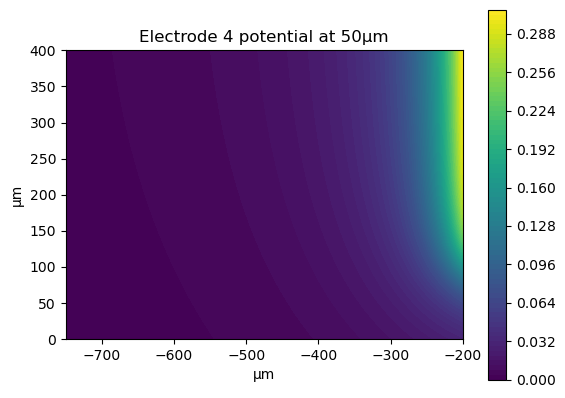

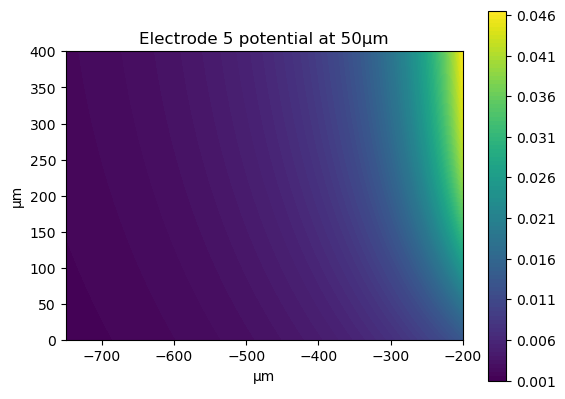

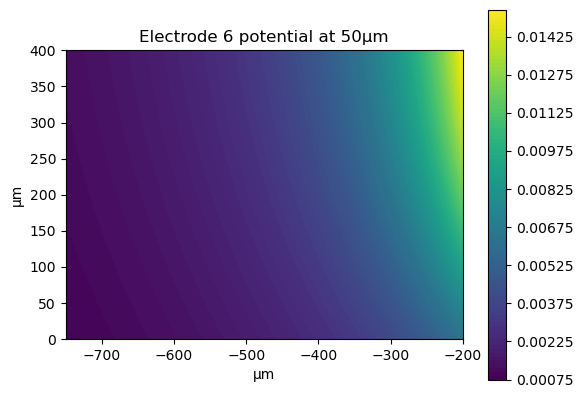

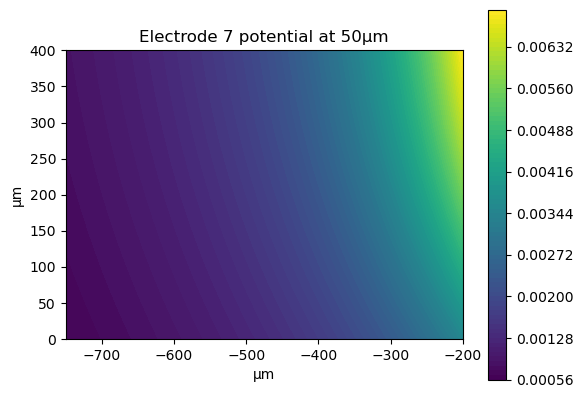

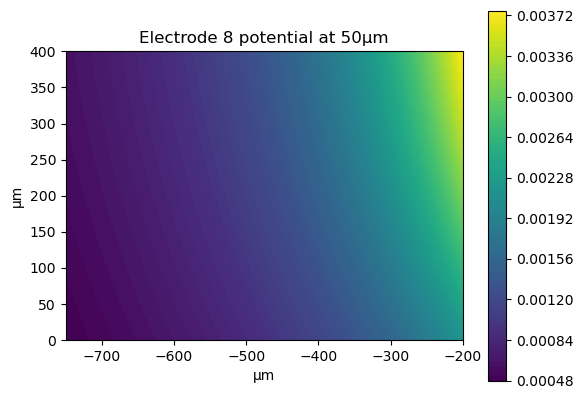

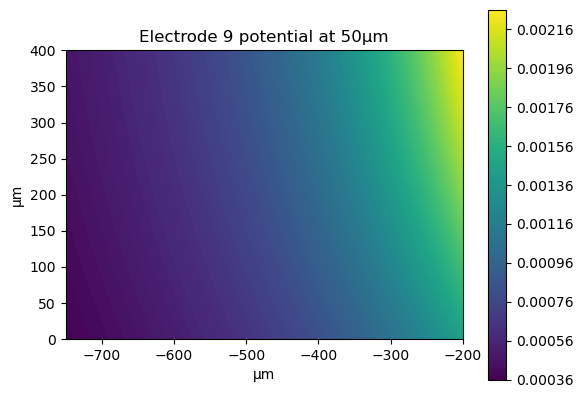

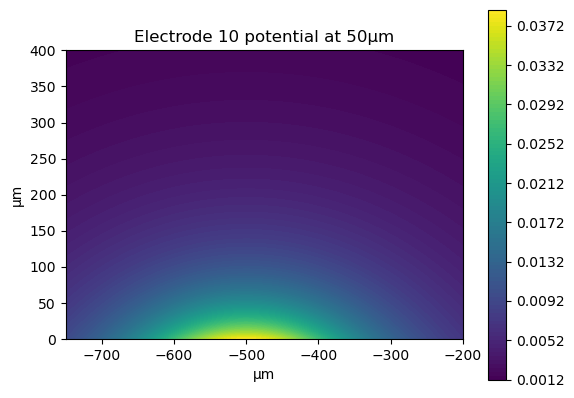

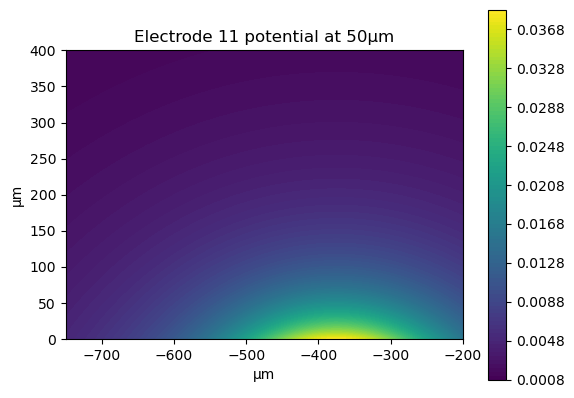

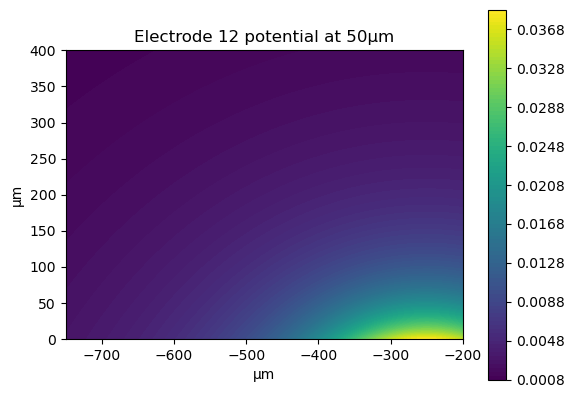

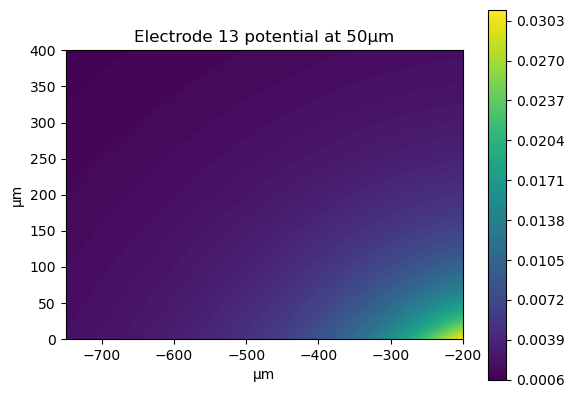

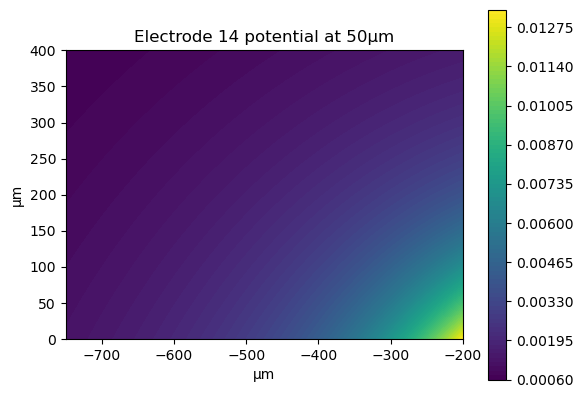

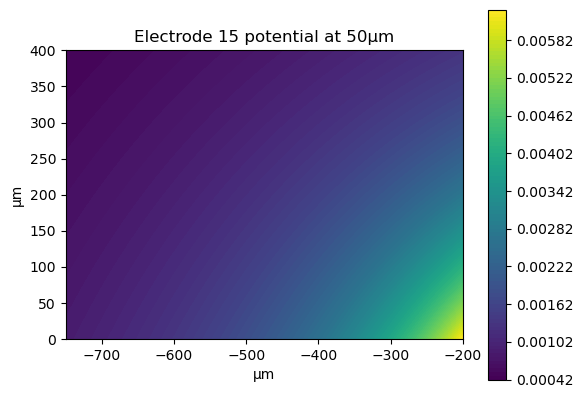

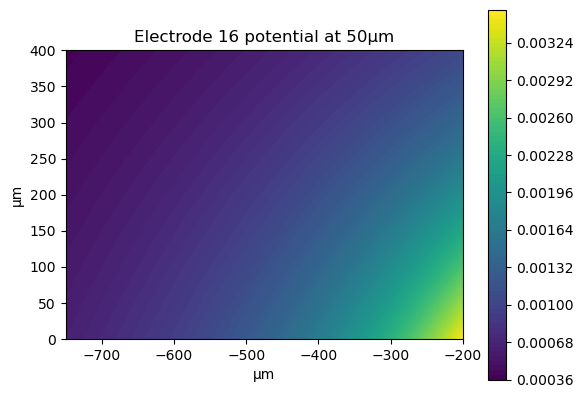

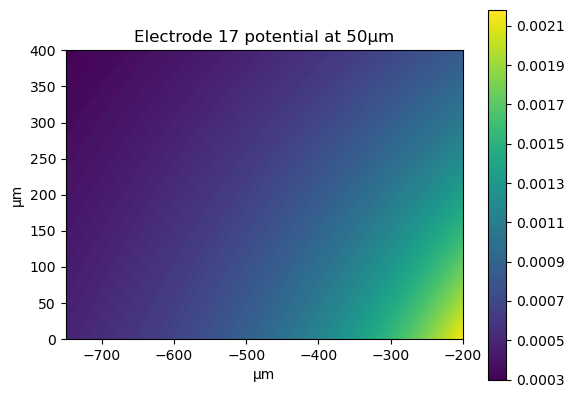

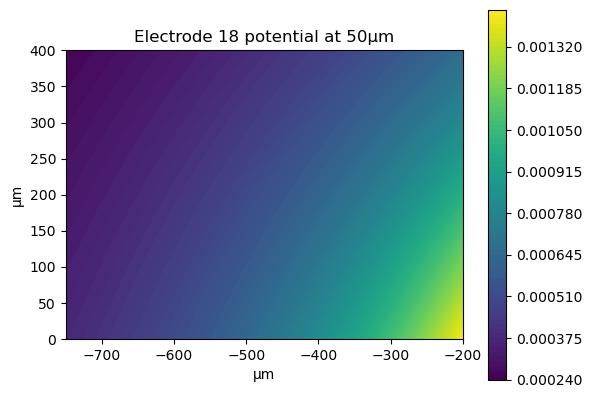

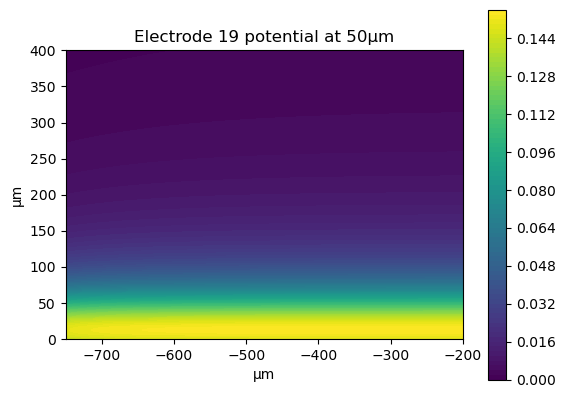

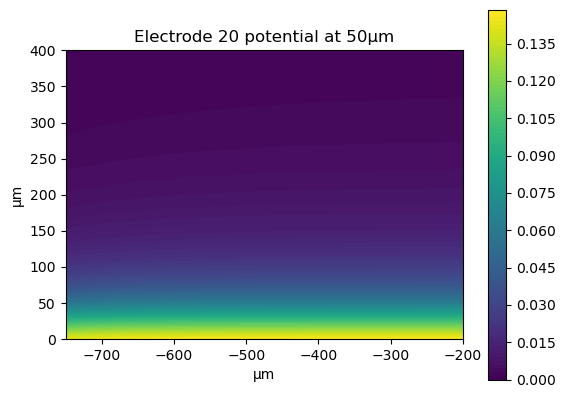

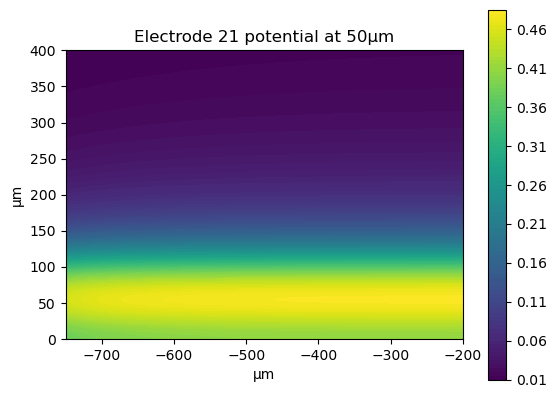

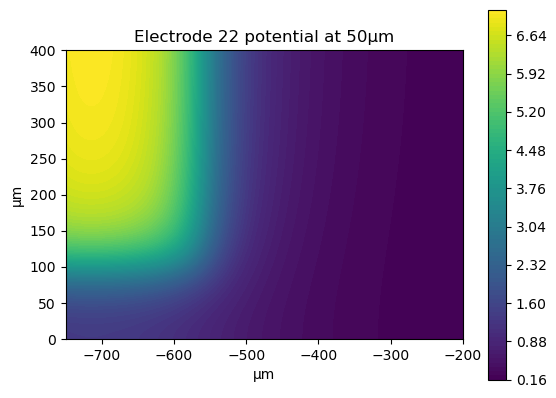

In [268]:
# potentials : array, shape (m, n, l)
#             Potential contributions. `m` is the electrode index (index
#             into `self`). `n` is the point index, `l = 2 * derivative +
#             1` is the derivative index.
for i in range(len(s.names)):
    # xy_only = np.delete(np.array(xy),2,1)
    # x = xy_only[:, 0]
    # y = xy_only[:, 1]
    potential = np.reshape(pot[i], (1000,1000))
    fig1, ax1 = plt.subplots()
    ax1.set_aspect('equal')
    ax1.set_title(f'Electrode {i+1} potential at 50µm')
    ax1.set_xlabel('µm')
    ax1.set_ylabel('µm')
    cf = ax1.contourf(tsx, tsy, potential, 100)
    fig1.colorbar(cf)

In [76]:
s1 = System([e for e in s if not e.rf])
derivs = "y z xx xy xz yy yzz".split()
x0 = np.array([0, 0, 0.1])
u = s1.shims([(x0 + 1e-3, None, deriv) for deriv in derivs])
fig, ax = plt.subplots(3, len(derivs)//2, figsize=(14, 14))
for d, ui, axi in zip(derivs, u, ax.flat):
    with s1.with_voltages(dcs=ui):
        s.plot_voltages(axi)
        axi.set_aspect("equal")
        axi.set_xlim(-r, r)
        axi.set_ylim(-r, r)
        um = ui[np.argmax(np.fabs(ui))]
        axi.set_title("%s, max=%g" % (d, um))

ValueError: solve failed: unknown

In [28]:
l = 1e-6 # µm length scale
u = 20. # V rf peak voltage
m = 40*ct.atomic_mass # Ca ion mass
q = 1*ct.elementary_charge # ion charge
o = 2*np.pi*30e6 # rf frequency in rad/s
s["r"].rf = u*np.sqrt(q/m)/(2*l*o)

x0 = s.minimum((0, 0, 1.), axis=(1, 2))

for line in s.analyze_static(x0, axis=(1, 2), m=m, q=-q, l=l, o=o):
    print(line)

ValueError: failed, 0, Warning: Desired error not necessarily achieved due to precision loss.,  message: Warning: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 1.7450189096682622
       x: [ 2.624e+00 -2.751e+00]
     nit: 3
     jac: [-5.680e-03 -1.412e-02]
    nfev: 82
    njev: 75
    nhev: 4